In [2]:
# This code cell will not be shown in the HTML version of this notebook
# import various basic libraries
import copy
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')

# import autograd functionality
import autograd.numpy as np

# imports from custom library
from mlrefined_libraries import nonlinear_superlearn_library as nonlib
from mlrefined_libraries import superlearn_library as superlearn

datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'
regress_plotter = nonlib.nonlinear_regression_demos
feature_plotter = nonlib.perceptron_scaling_tools
classification_plotter = superlearn.classification_static_plotter.Visualizer();

# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True
%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [33]:
# relu activation
def activation(t):
#     return np.maximum(0,t)
    return np.tanh(t)

In [4]:
# fully evaluate our network features using the tensor of weights in w
def feature_transforms(a, w):    
    # loop through each layer matrix
    for W in w:
        #  pad with ones (to compactly take care of bias) for next layer computation        
        o = np.ones((1,np.shape(a)[1]))
        a = np.vstack((o,a))
        
        # compute linear combination of current layer units
        a = np.dot(a.T, W).T
    
        # pass through activation
        a = activation(a)
    return a

In [13]:
# compute eigendecomposition of data covariance matrix for PCA transformation
def PCA(x,**kwargs):
    # regularization parameter for numerical stability
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # create the correlation matrix
    P = float(x.shape[1])
    Cov = 1/P*np.dot(x,x.T) + lam*np.eye(x.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    d,V = np.linalg.eigh(Cov)
    return d,V

# PCA-sphereing - use PCA to normalize input features
def PCA_sphereing(x,**kwargs):
    # Step 1: mean-center the data
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means

    # Step 2: compute pca transform on mean-centered data
    d,V = PCA(x_centered,**kwargs)

    # Step 3: divide off standard deviation of each (transformed) input, 
    # which are equal to the returned eigenvalues in 'd'.  
    stds = (d[:,np.newaxis])**(0.5)

    # check to make sure thta x_stds > small threshold, for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind]
        adjust = np.zeros((stds.shape))
        adjust[ind] = 1.0
        stds += adjust

    normalizer = lambda data: np.dot(V.T,data - x_means)/stds

    # create inverse normalizer
    inverse_normalizer = lambda data: np.dot(V,data*stds) + x_means

    # return normalizer 
    return normalizer,inverse_normalizer

In [16]:
# a multilayer perceptron network, note the input w is a tensor of weights, with 
# activation output normalization
def feature_transforms_batch_normalized(a, w):    
    # loop through each layer matrix
    for W in w:
        #  pad with ones (to compactly take care of bias) for next layer computation        
        o = np.ones((1,np.shape(a)[1]))
        a = np.vstack((o,a))
        
        # compute linear combination of current layer units
        a = np.dot(a.T, W).T
    
        # pass through activation
        a = activation(a)
        
        # NEW - perform standard normalization to the activation outputs
        normalizer,inverse_normalizer = PCA_sphereing(a)
        a = normalizer(a)
    return a

<IPython.core.display.Javascript object>


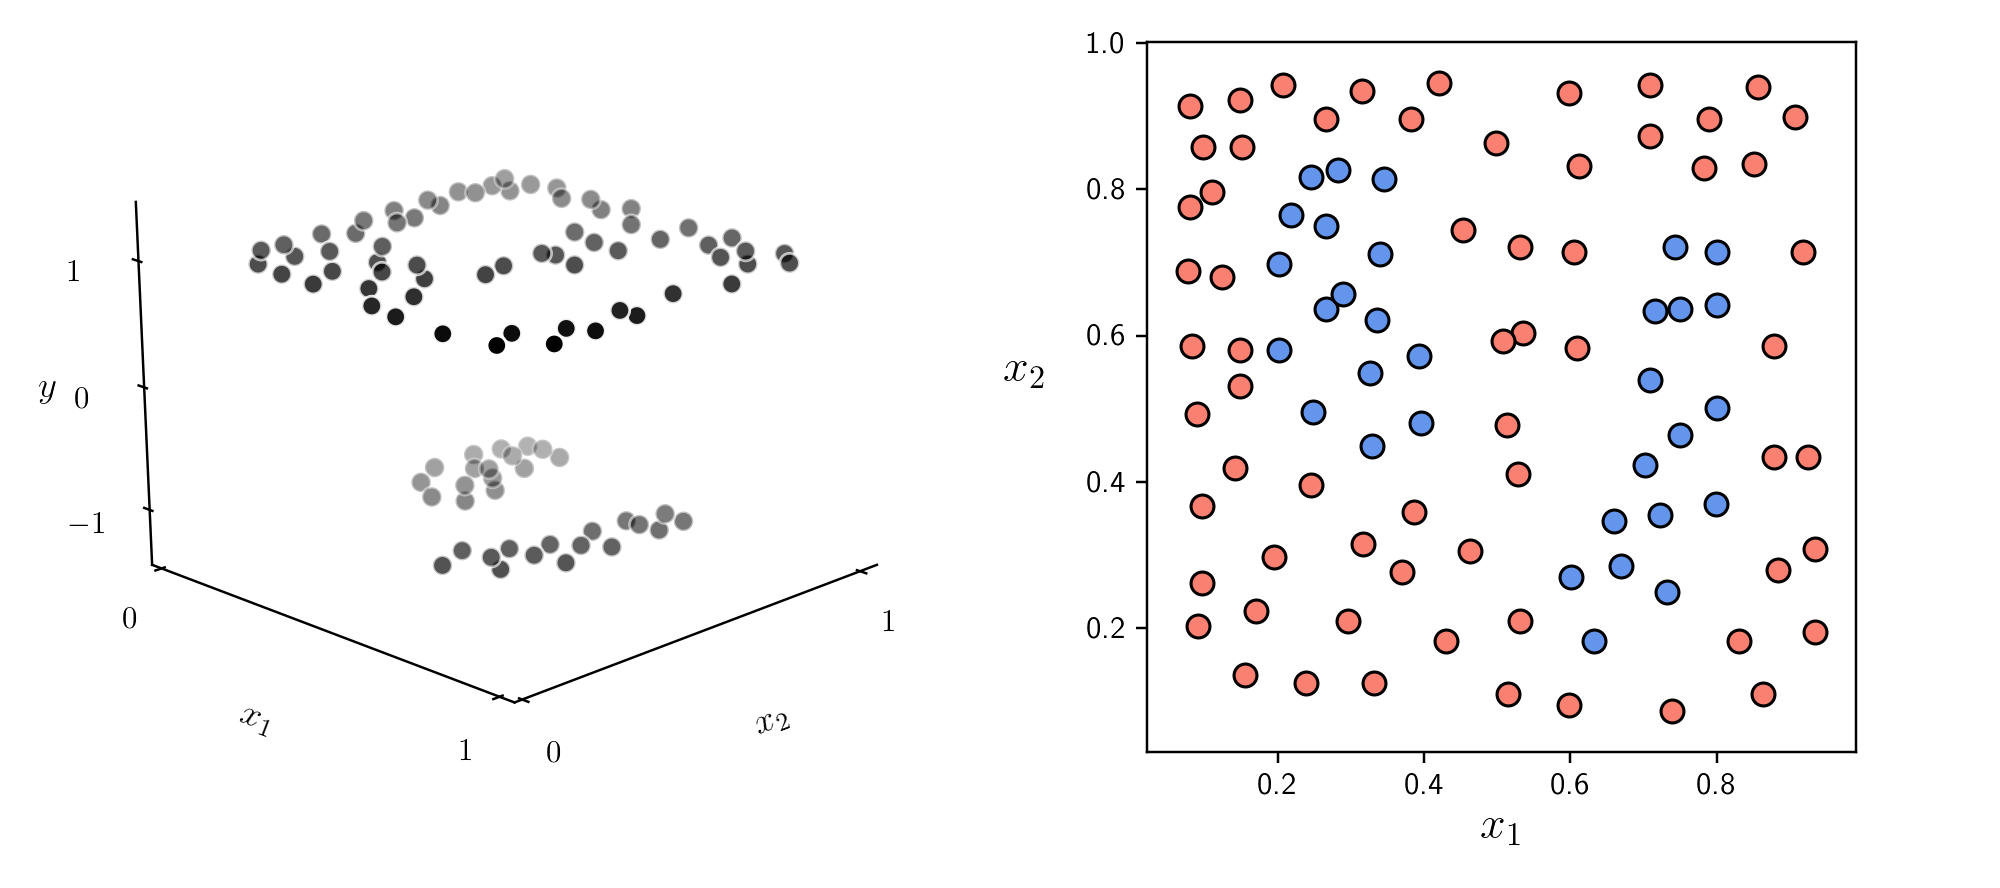

In [7]:
# create instance of linear regression demo, used below and in the next examples
viewer = nonlib.nonlinear_classification_visualizer.Visualizer(datapath + '2eggs_data.csv')
x = viewer.x.T
y = viewer.y[np.newaxis,:]

# an implementation of the least squares cost function for linear regression for N = 2 input dimension datasets
viewer.plot_data()

In [8]:
# load in a set of random weights from memory
w = pickle.load( open(datapath +"13_2_single_layer_weights.p", "rb" ) )

In [17]:
# run gradient descent to minimize a batch normalized single layer perceptron model
alpha_choice = 10**(-1); max_its = 100;
run2 = nonlib.basic_runner.Setup(x,y,feature_transforms_batch_normalized,'softmax',normalize = 'standard')
run2.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)


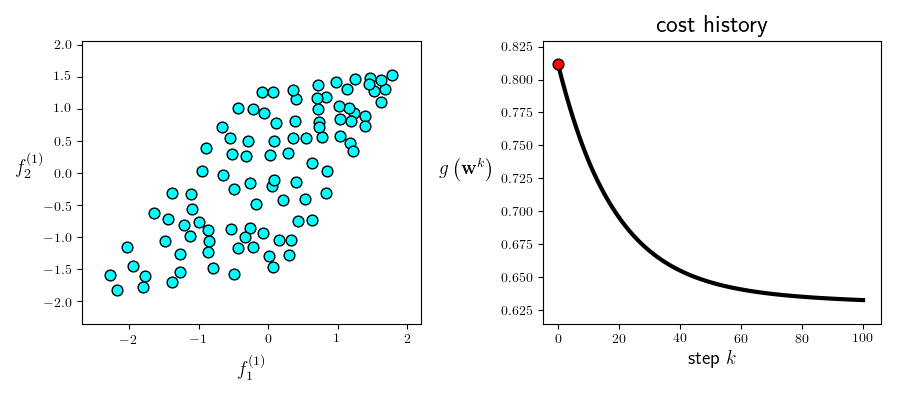
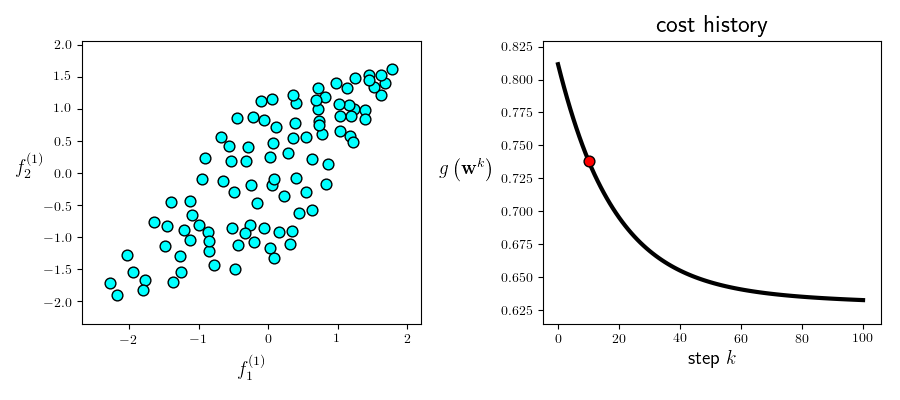
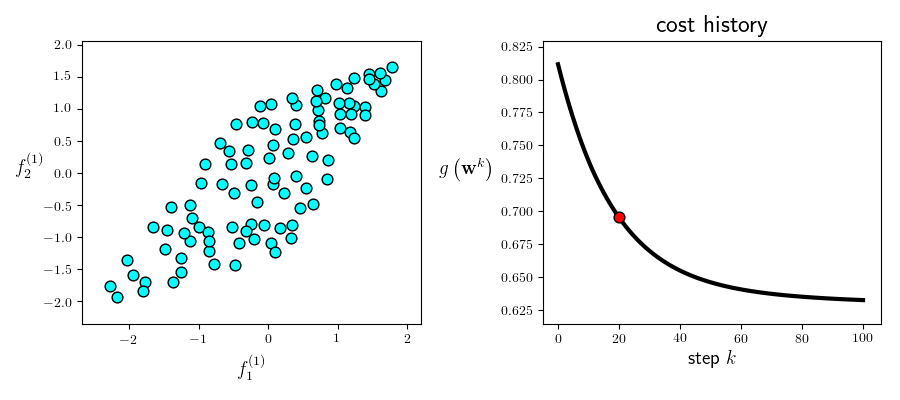
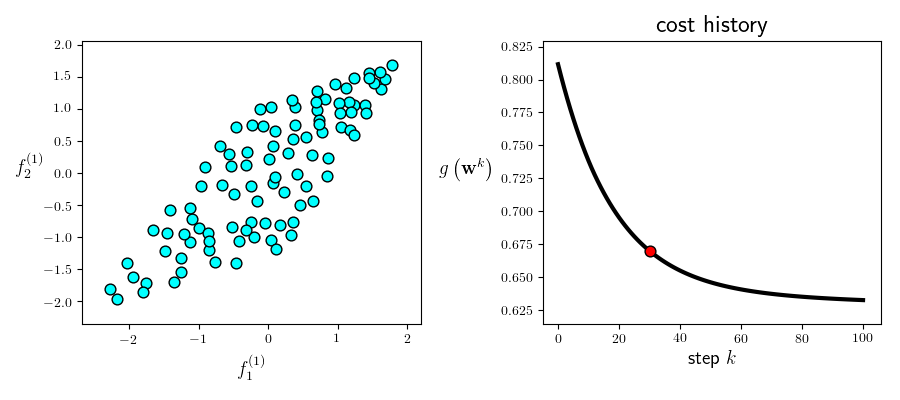
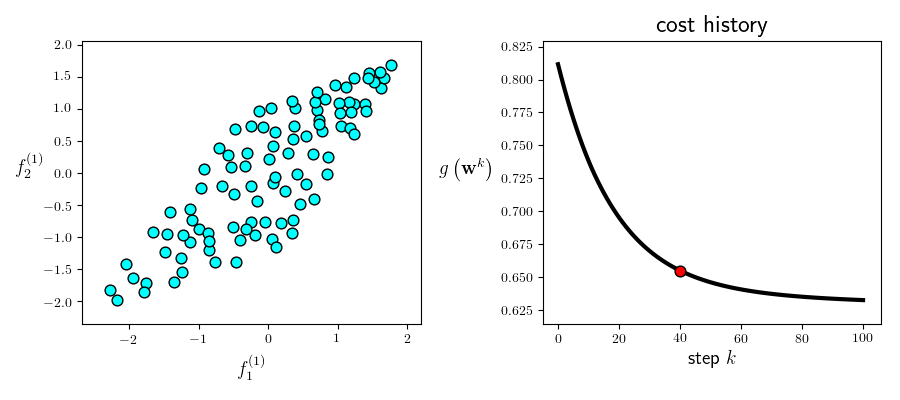
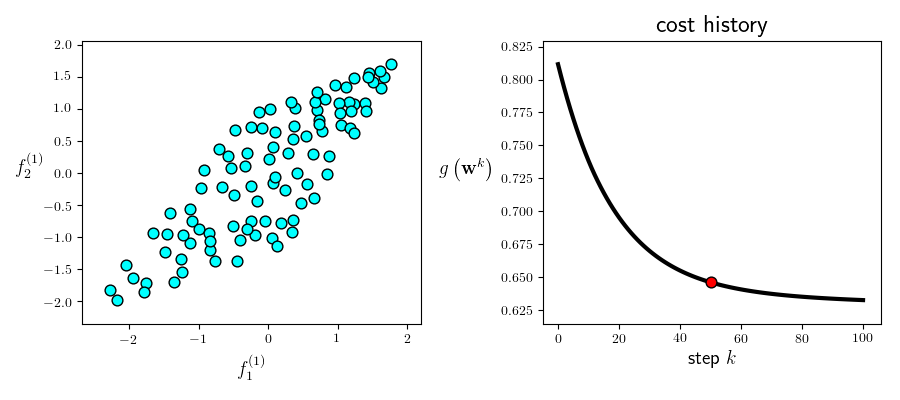
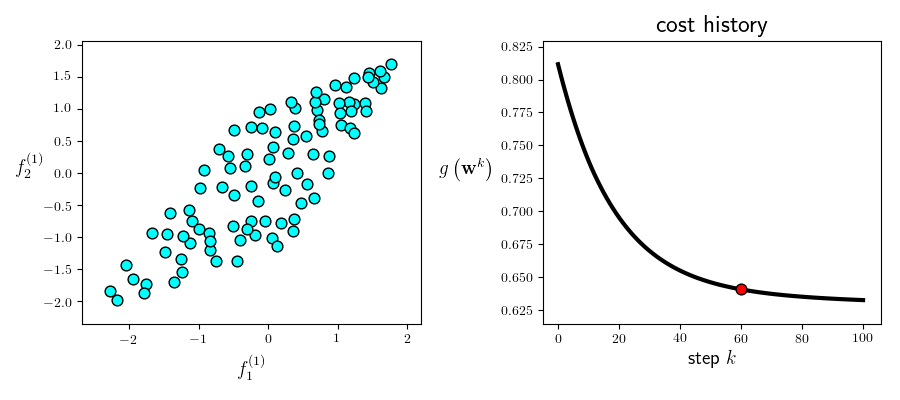
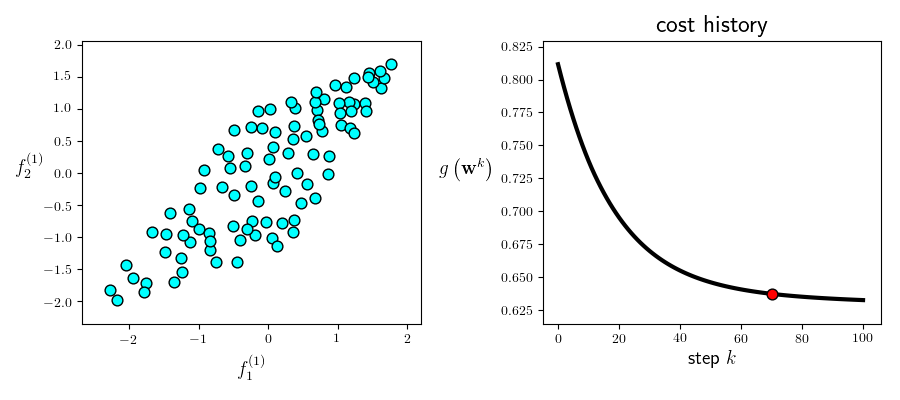
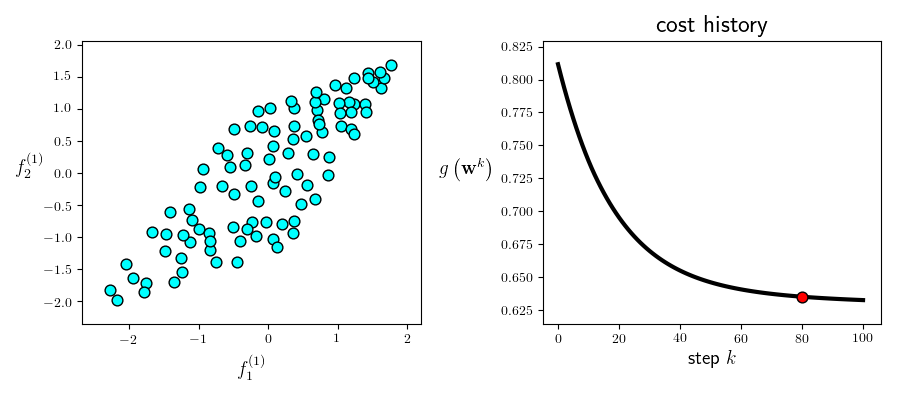
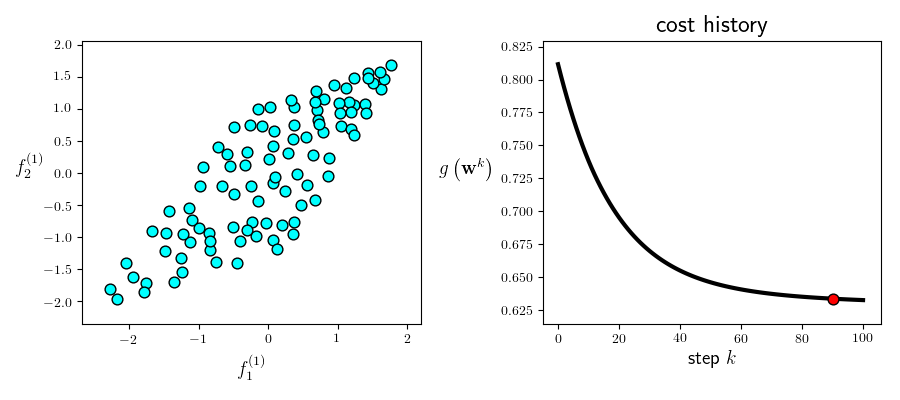
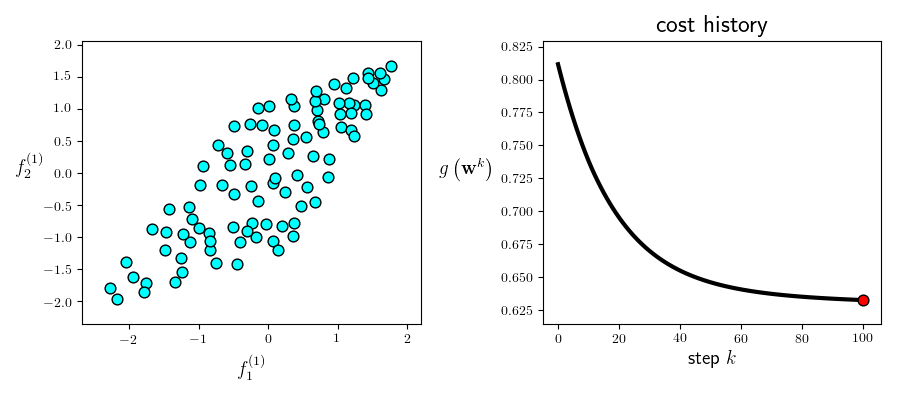

In [18]:
# show a plot of the distribution of each feature
frames = 10
demo2 = feature_plotter.Visualizer()
demo2.shifting_distribution(run2,frames,x,show_history = True,normalize = True)

#### <span style="color:#a50e3e;">Example 2. </span>  The shifting distributions / covariate shift of a multilayer perceptron

In [19]:
# load in a set of weights from memory
w = pickle.load( open(datapath +"13_2_multi_layer_weights.p", "rb" ) )

In [25]:
# run gradient descent to minimize a batch normalized multilayer perceptron model
alpha_choice = 10**(-2); max_its = 10000;
run4 = nonlib.basic_runner.Setup(x,y,feature_transforms_batch_normalized,'softmax',normalize = 'standard')
run4.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)


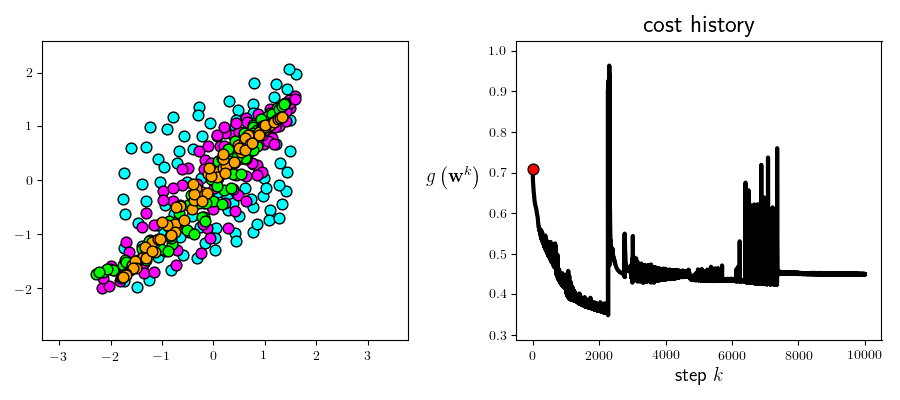
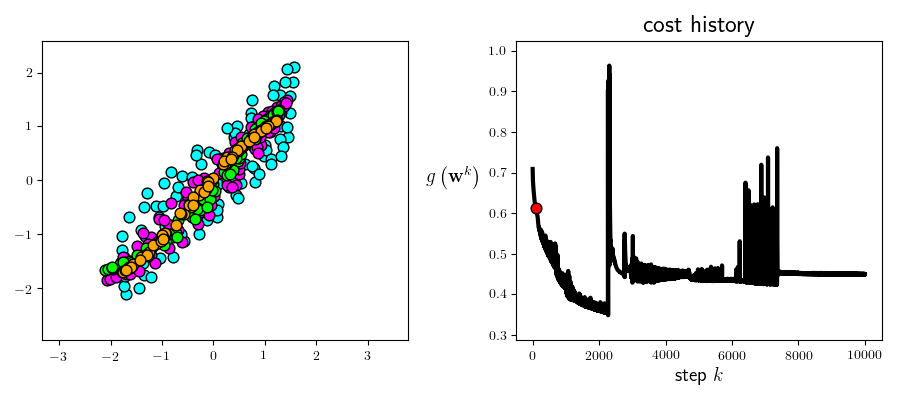
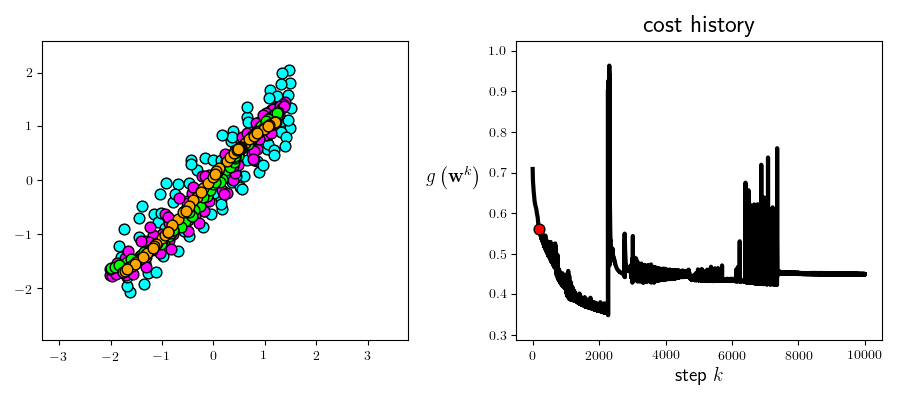
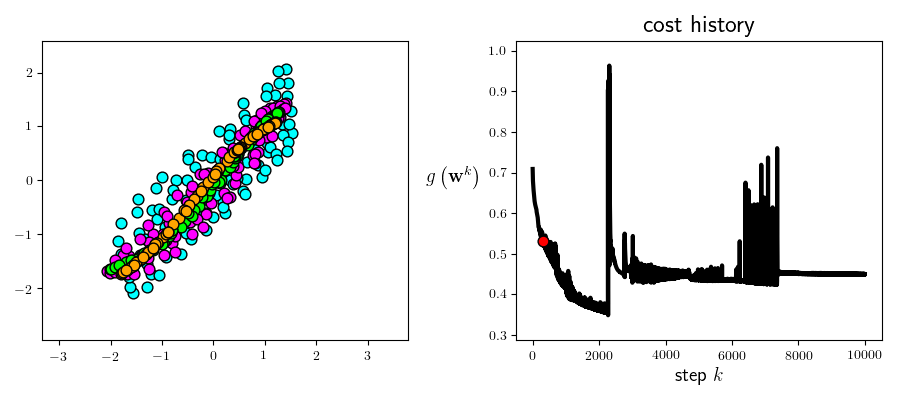
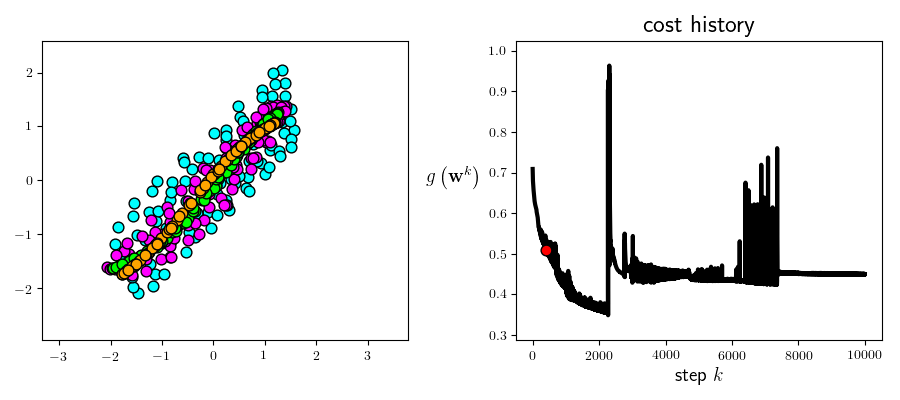
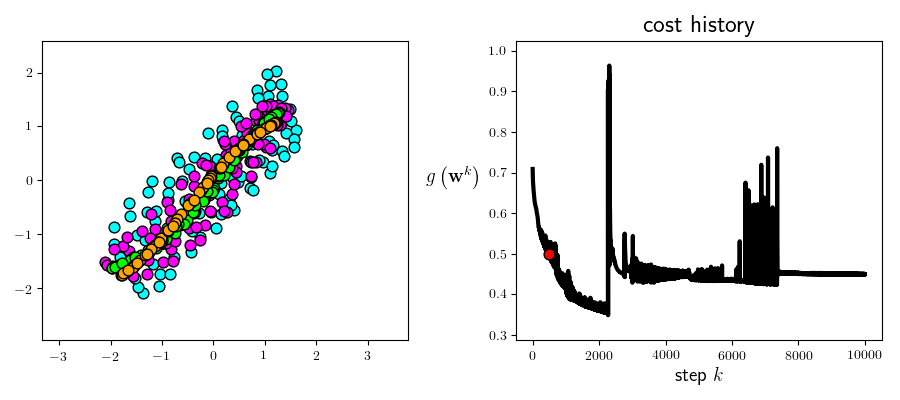
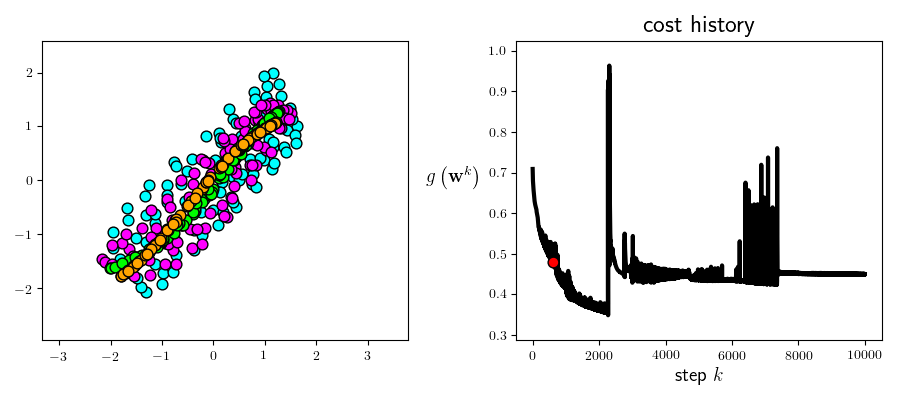
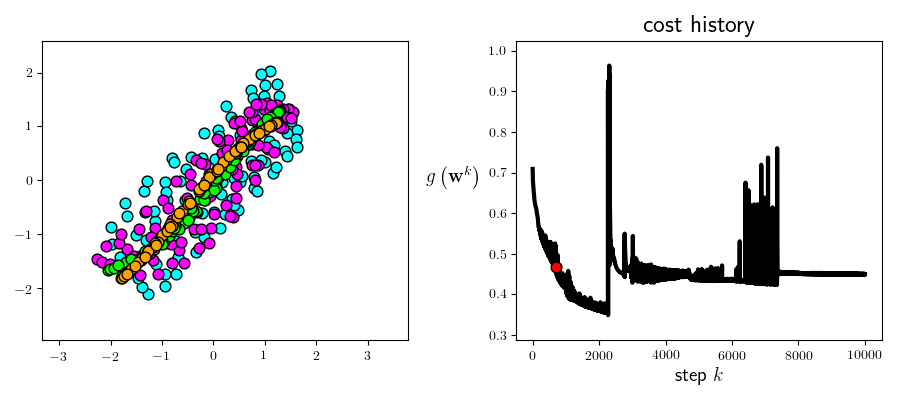
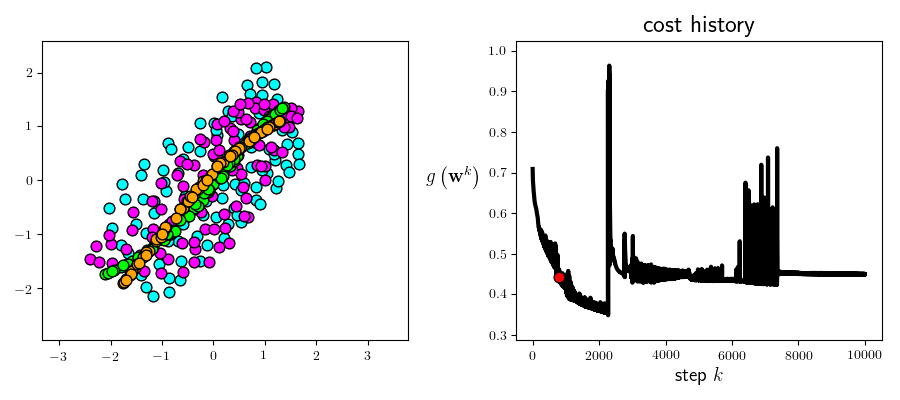
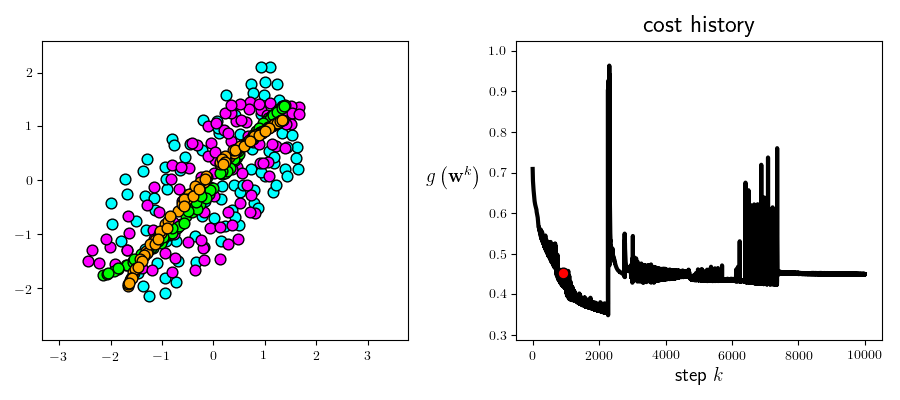
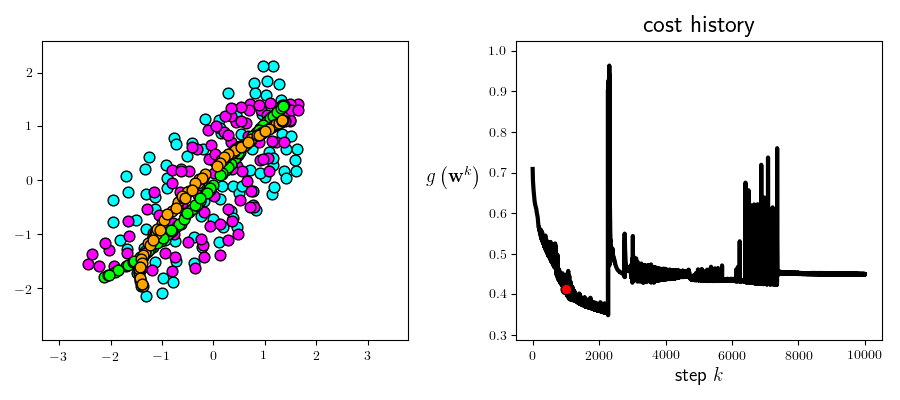
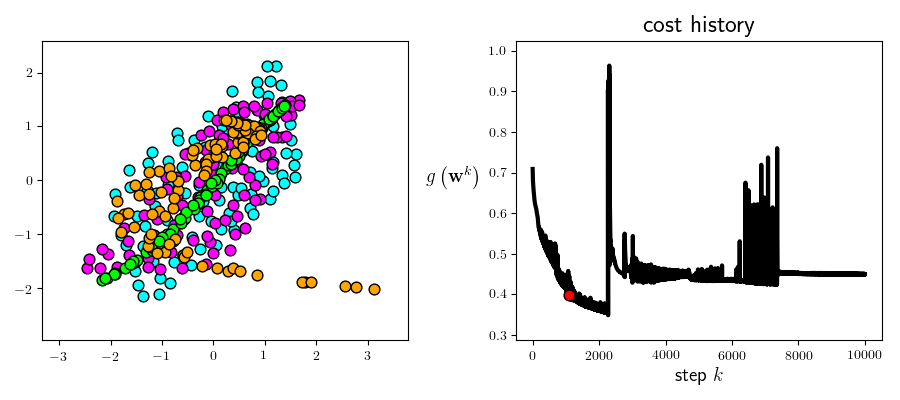
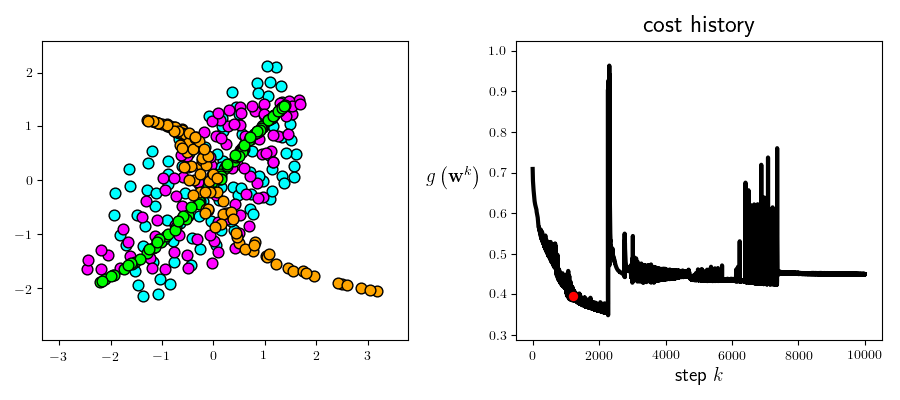
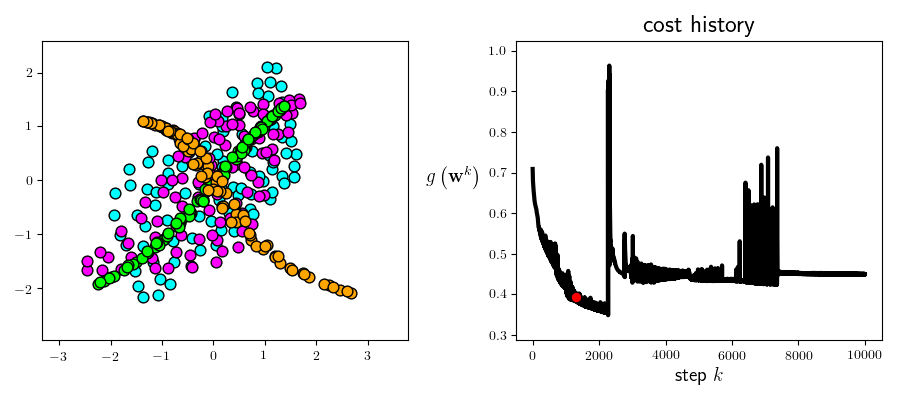
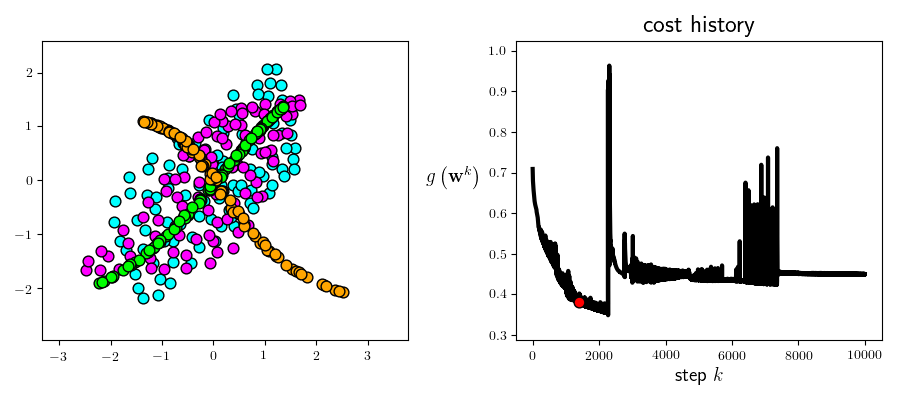
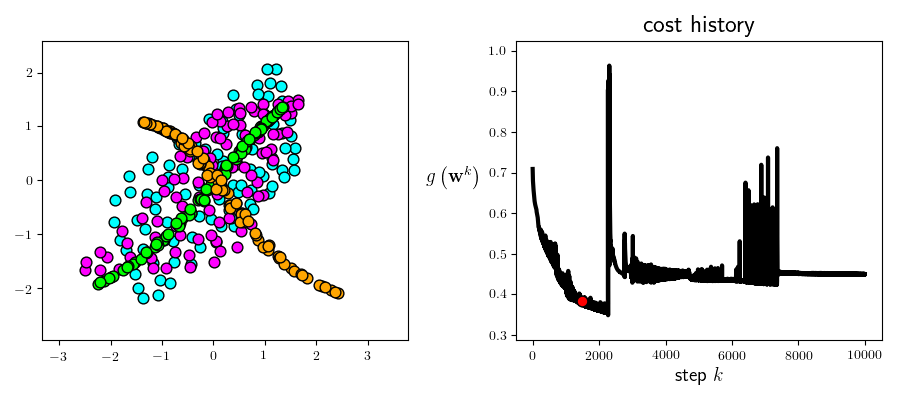
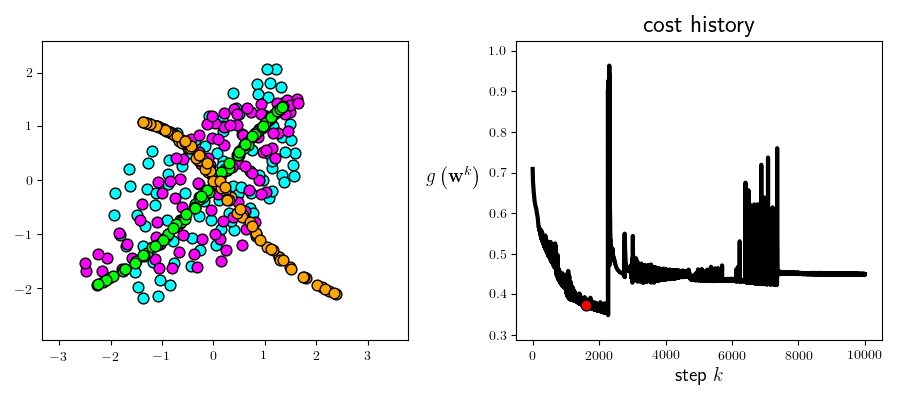
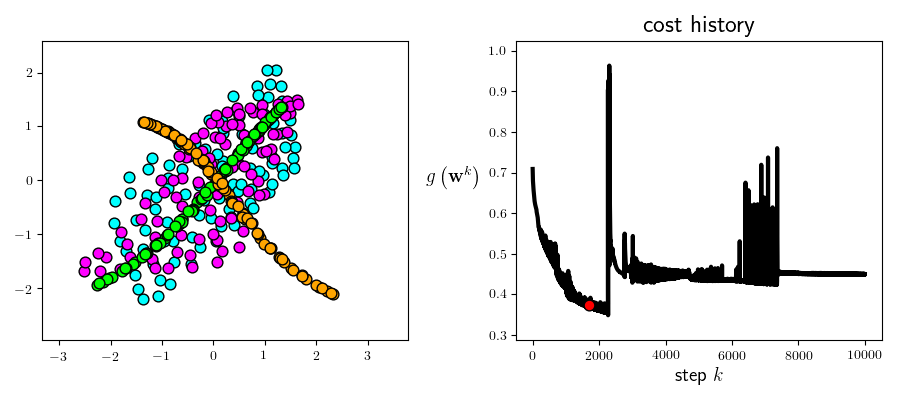
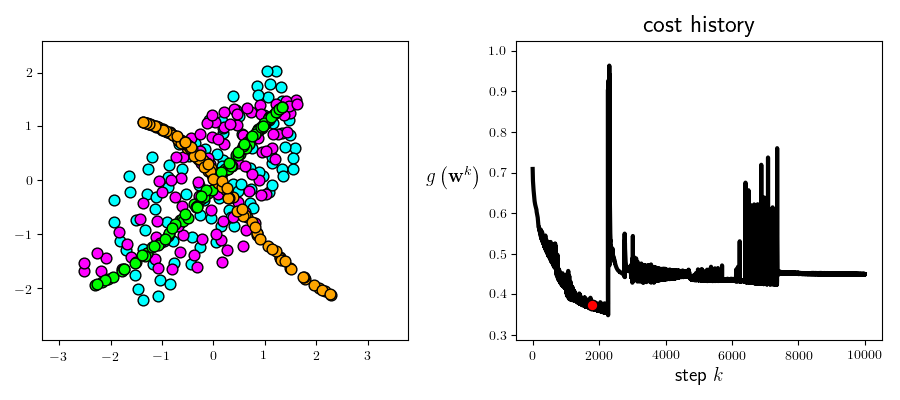
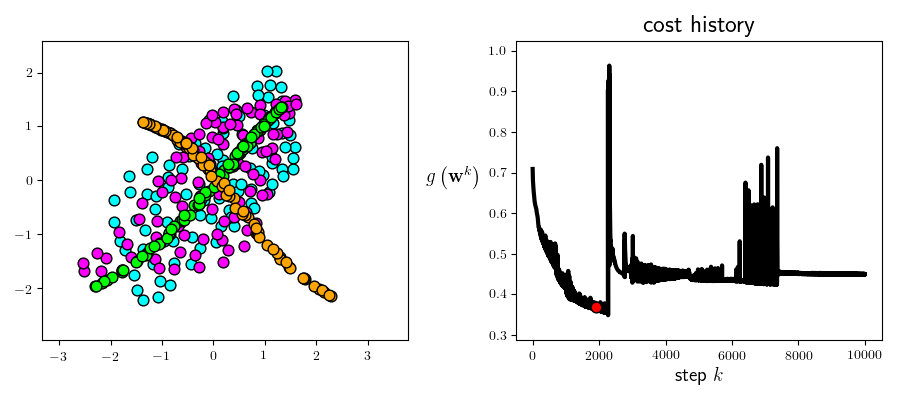
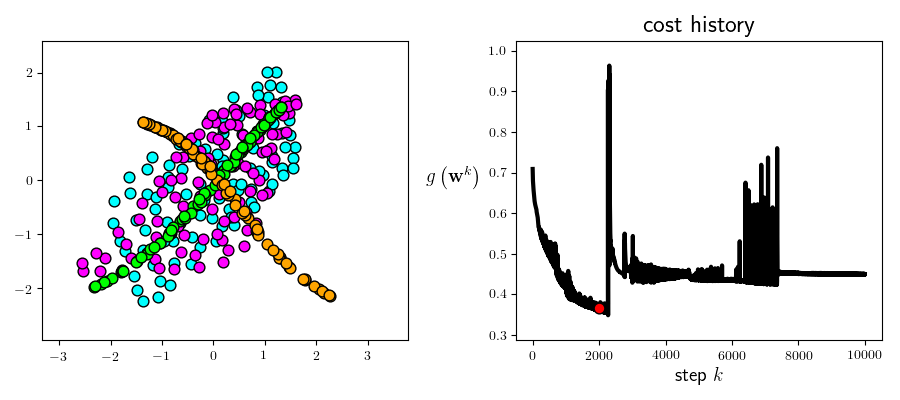
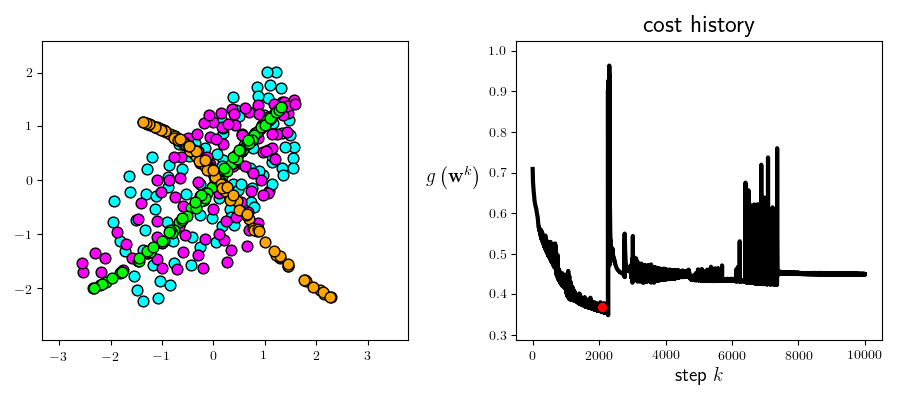
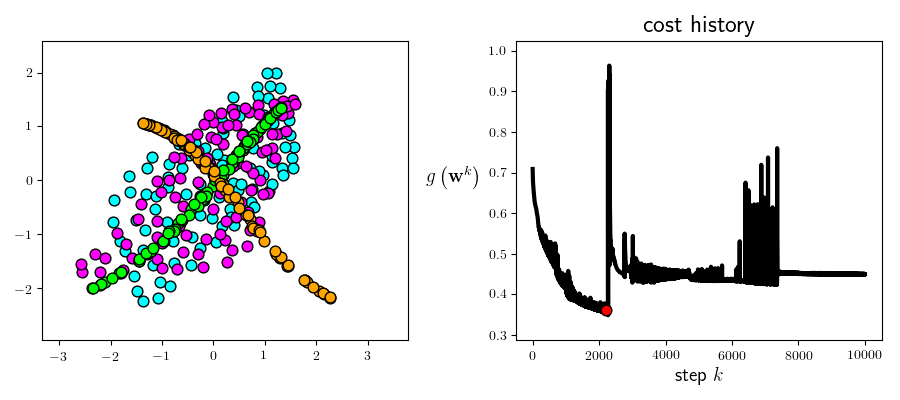
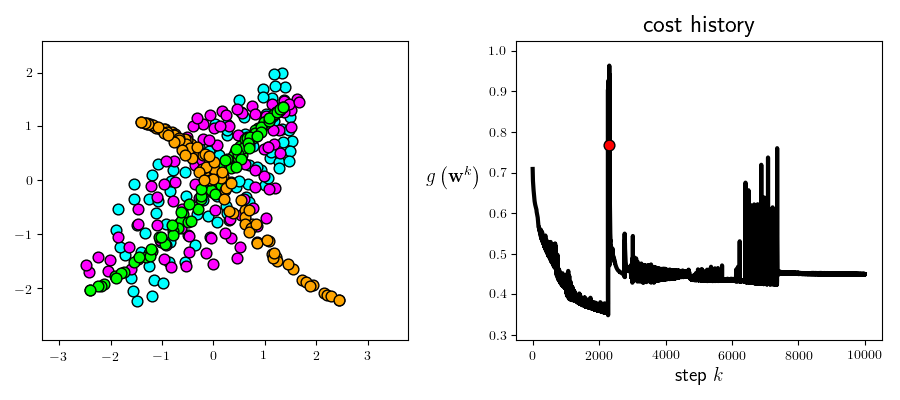
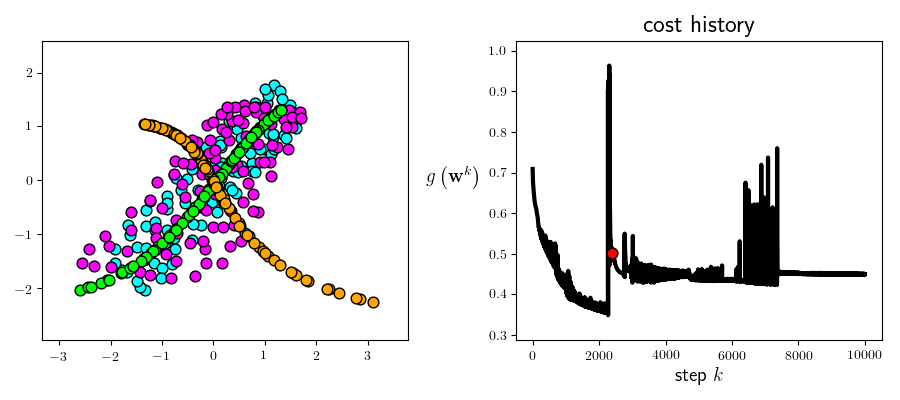
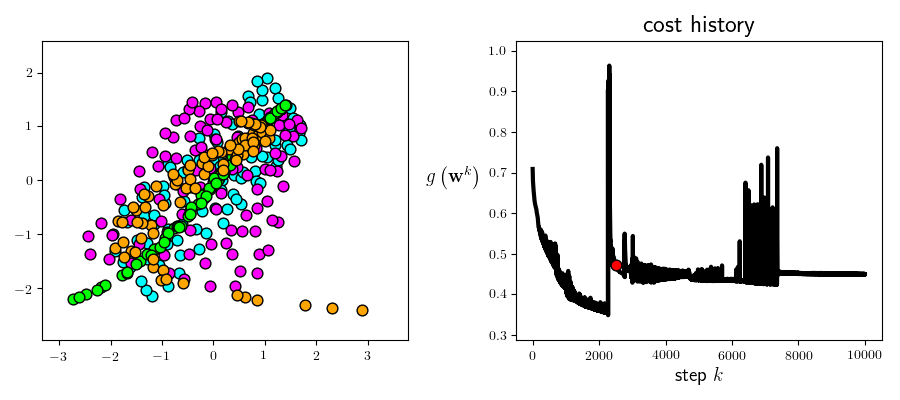
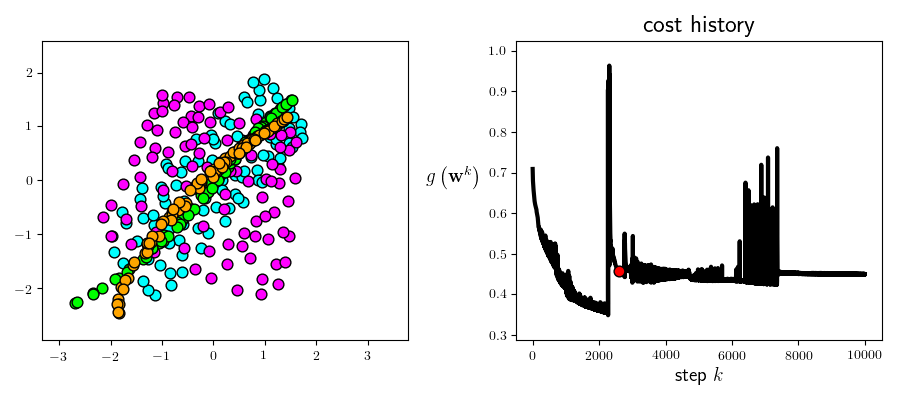
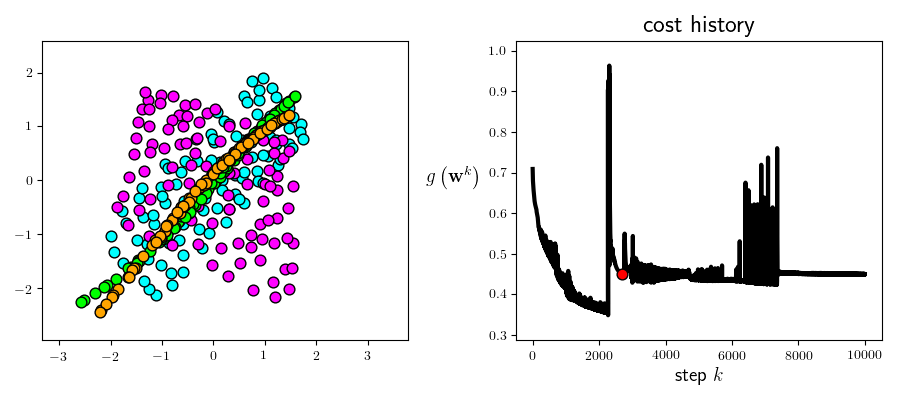
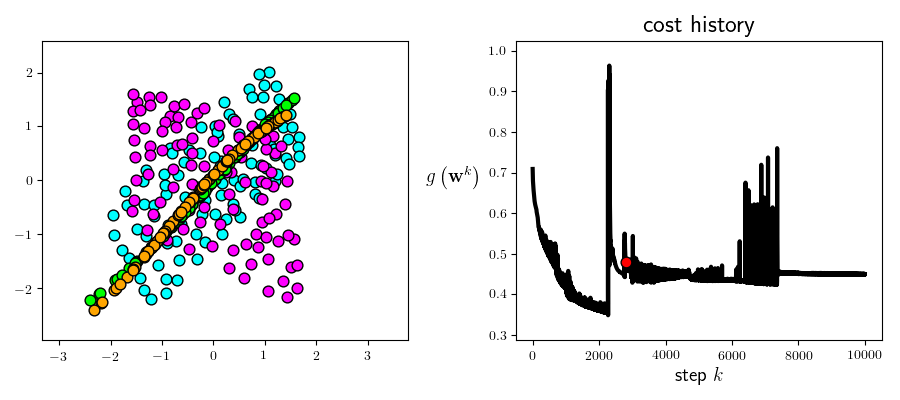
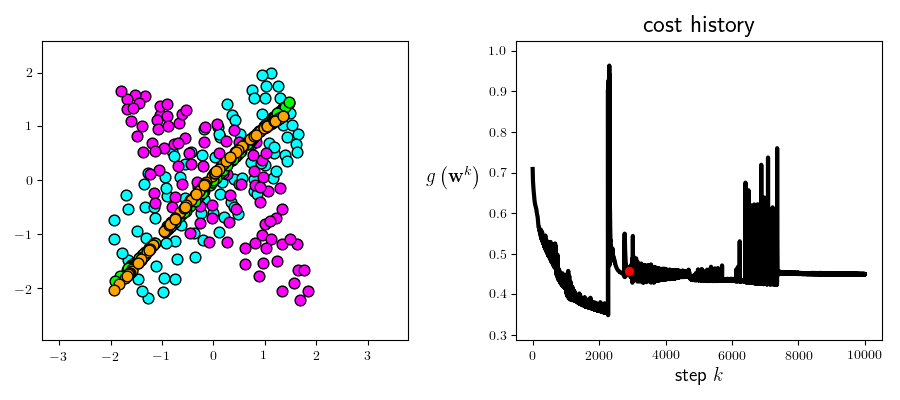
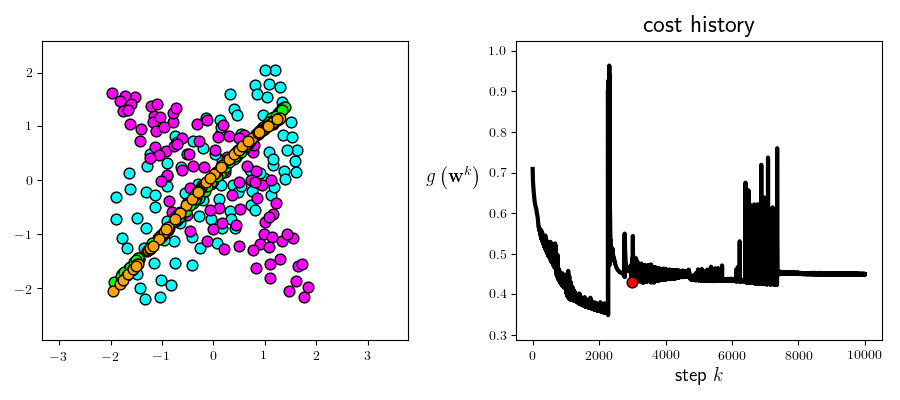
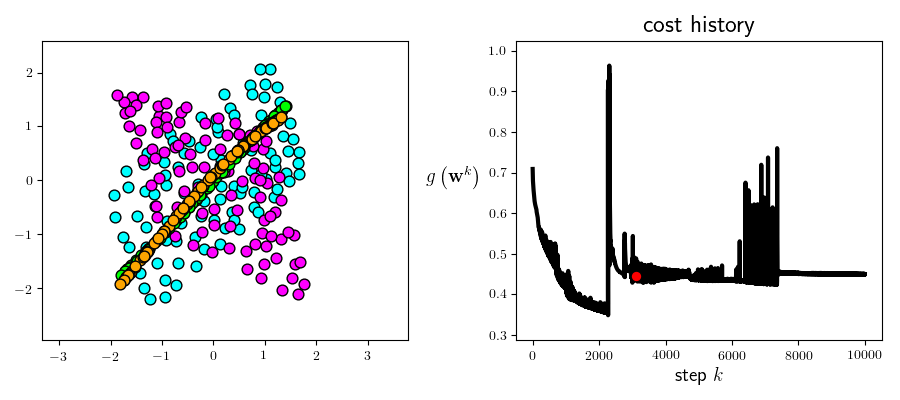
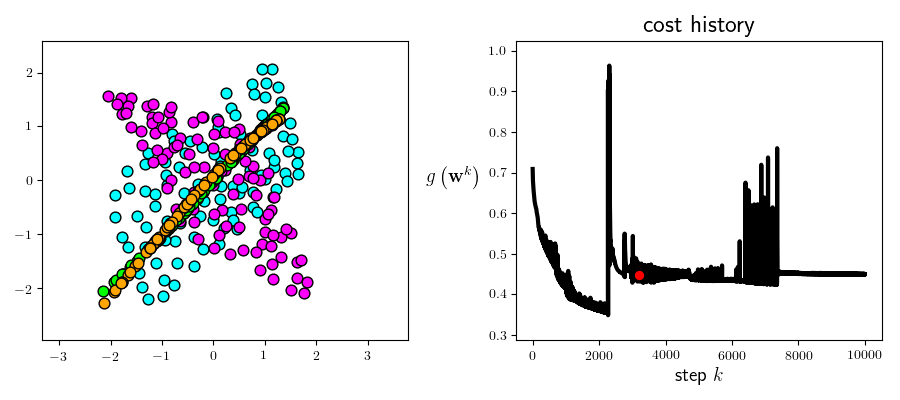
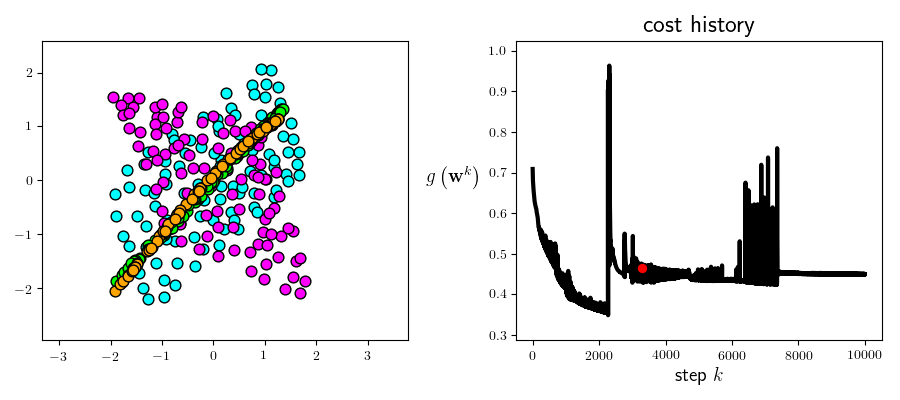
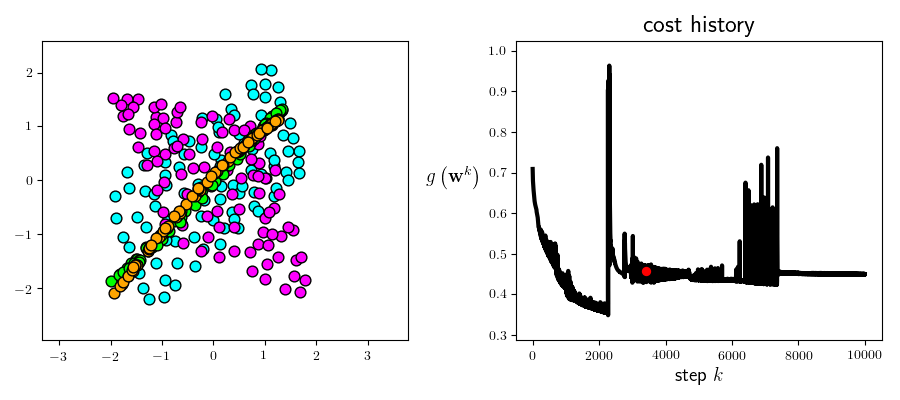
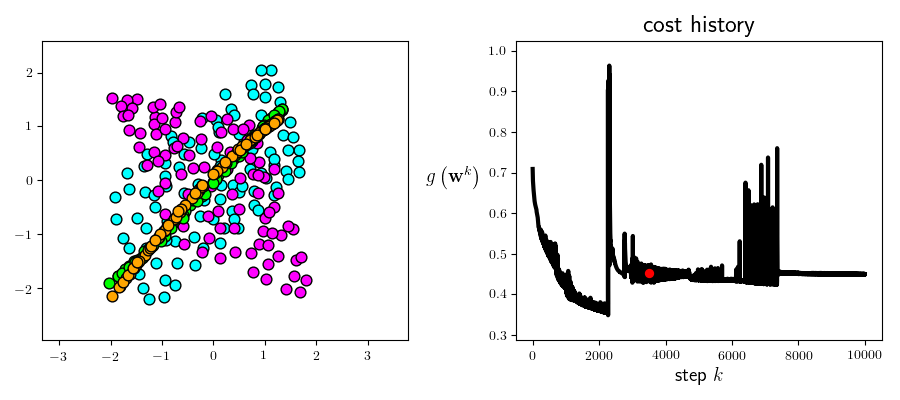
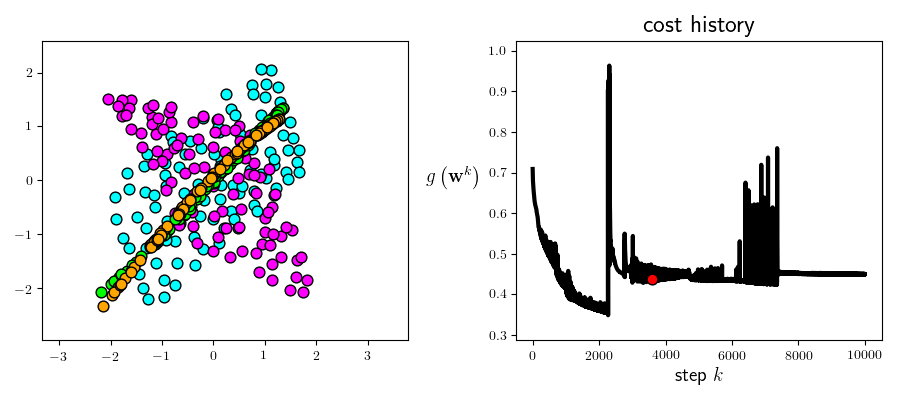
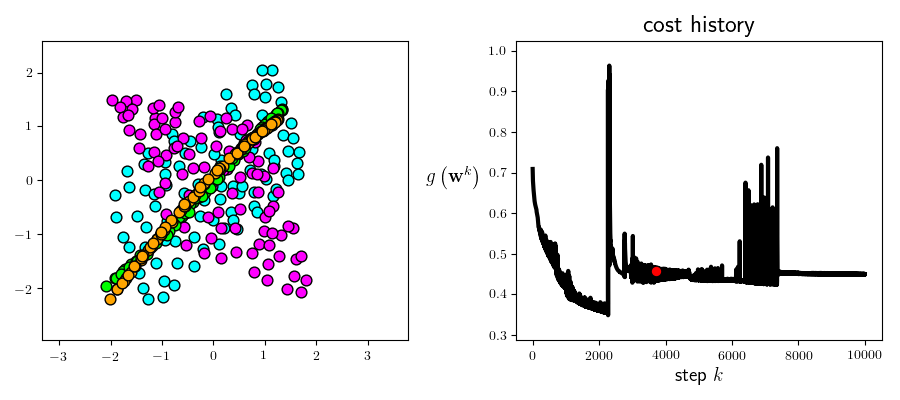
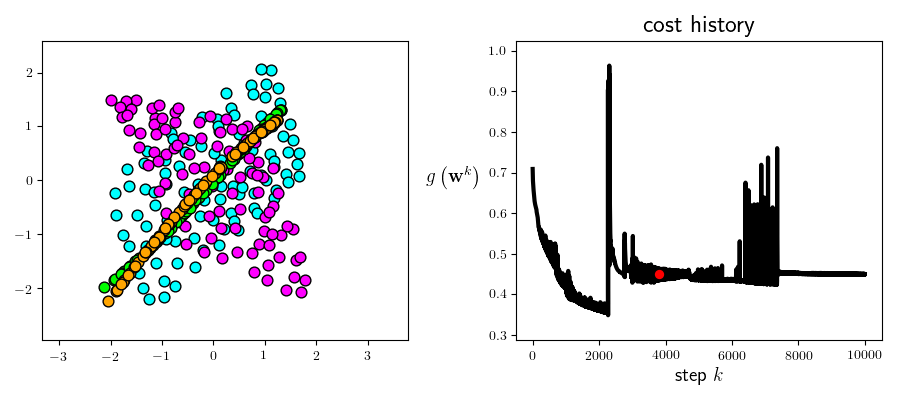
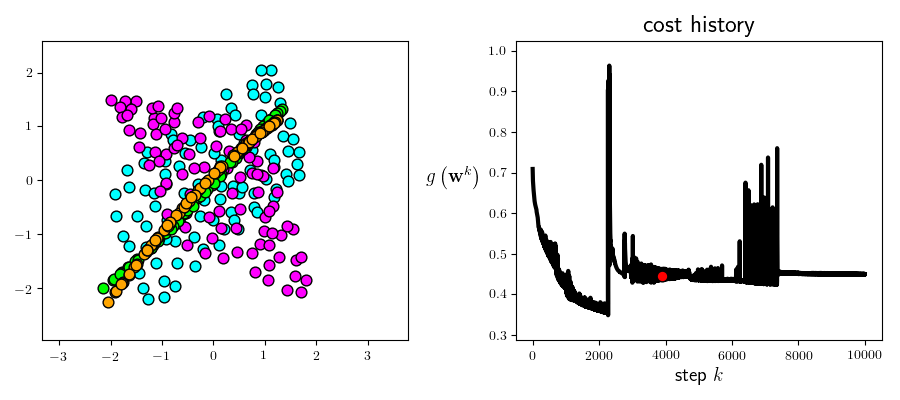
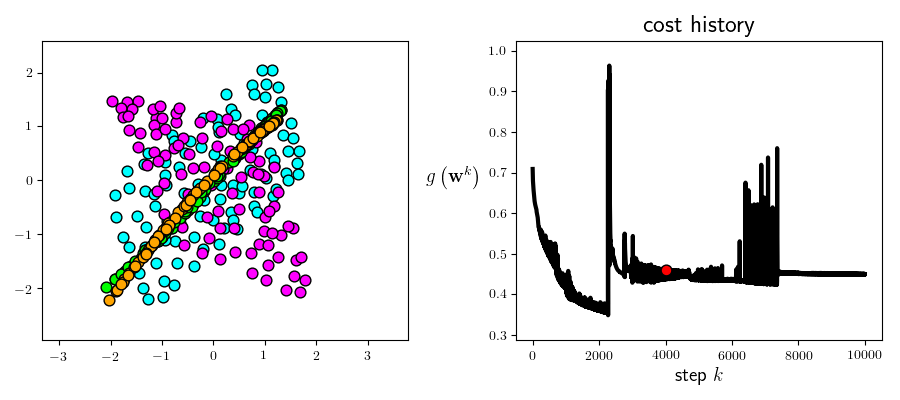
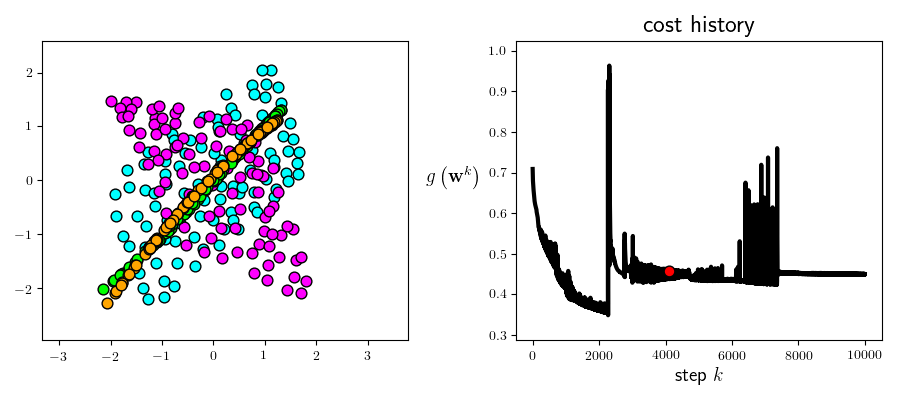
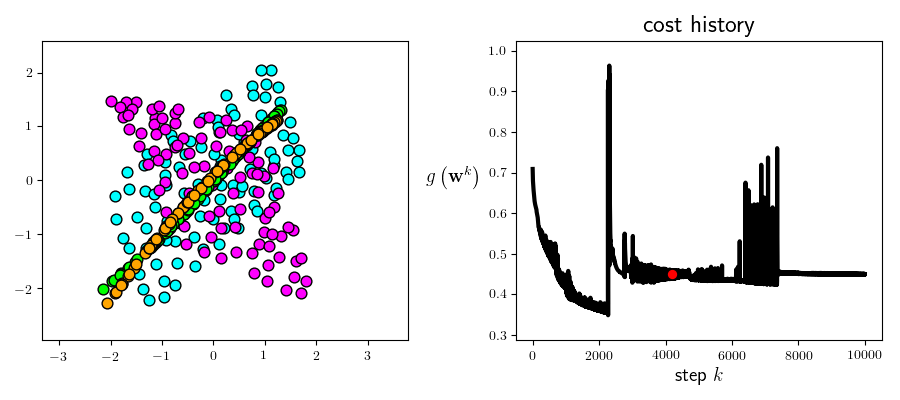
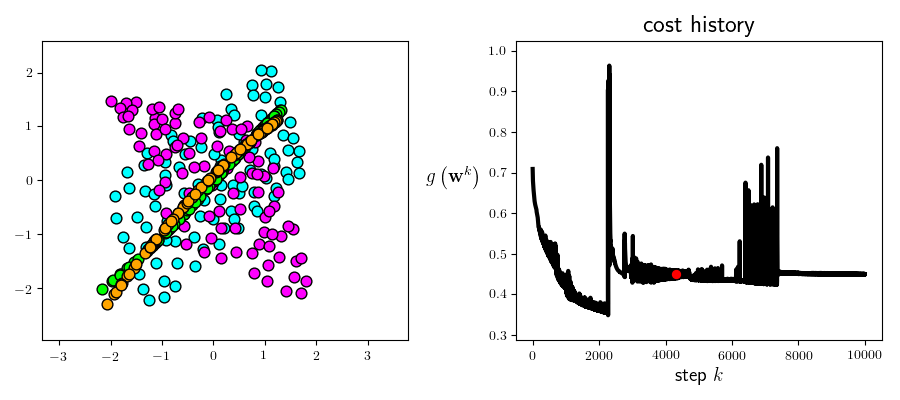
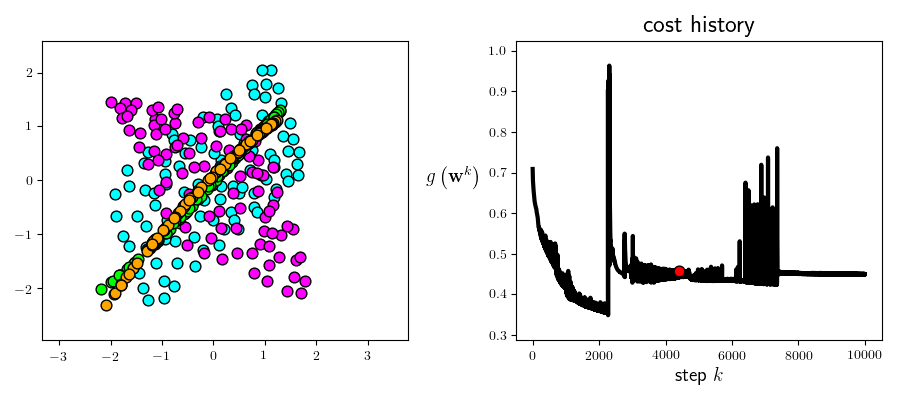
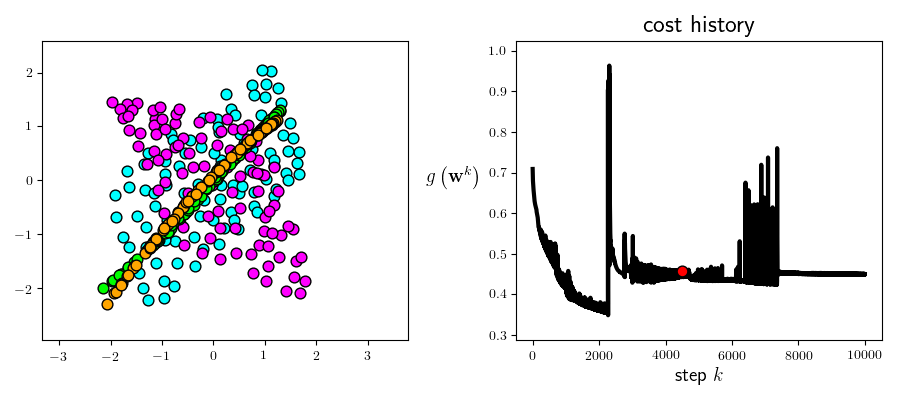
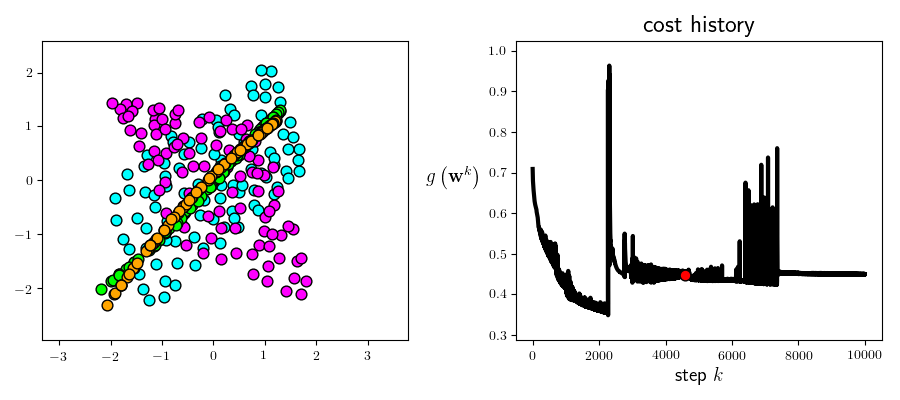
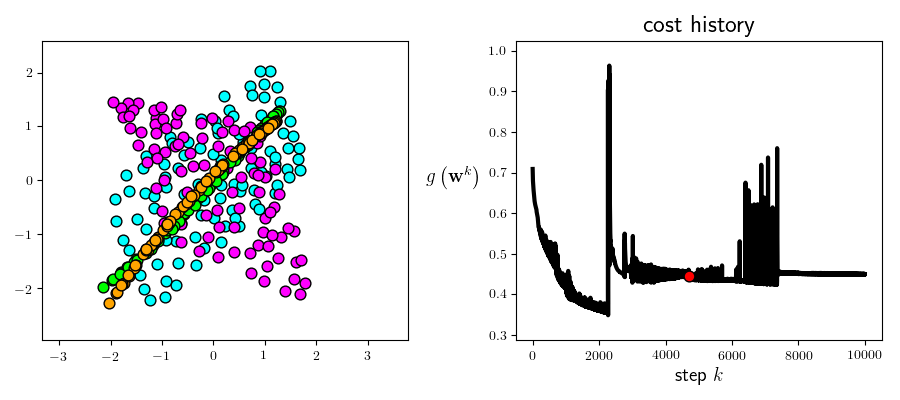
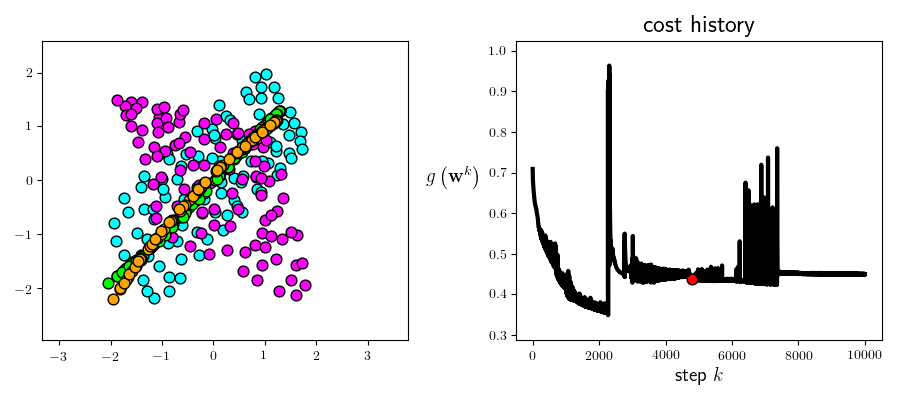
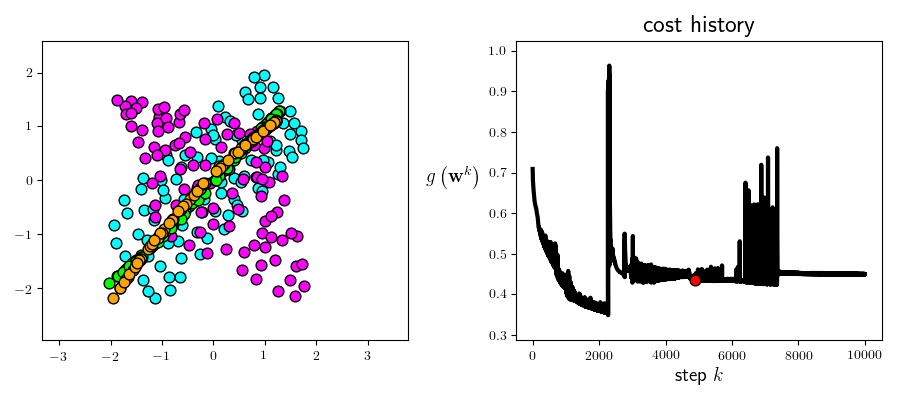
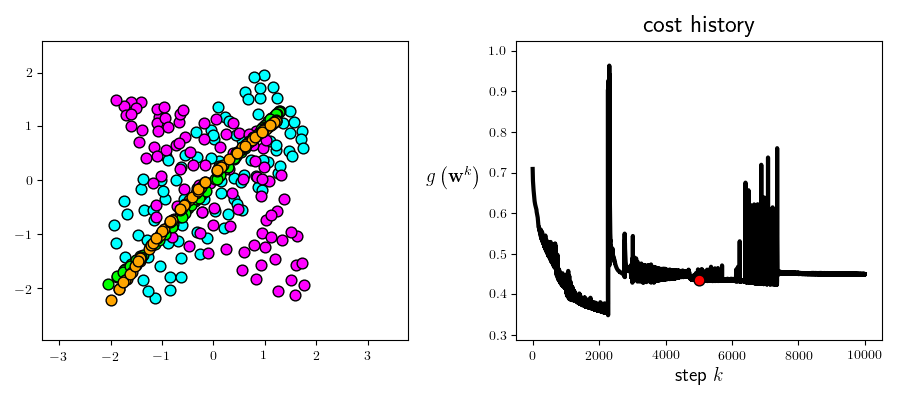
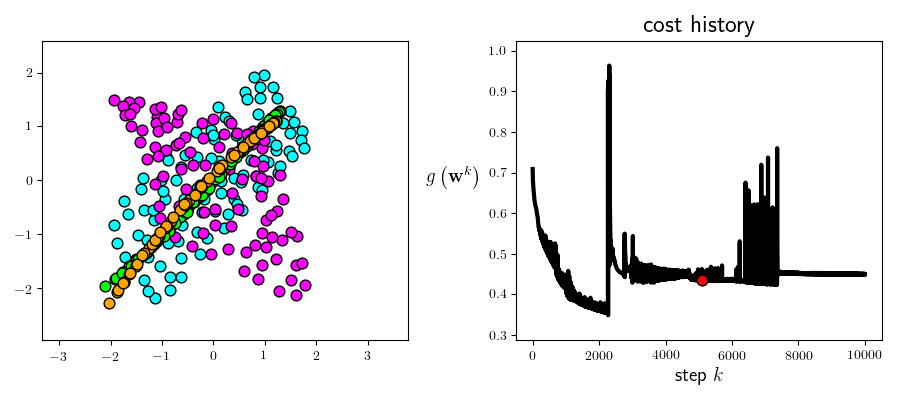
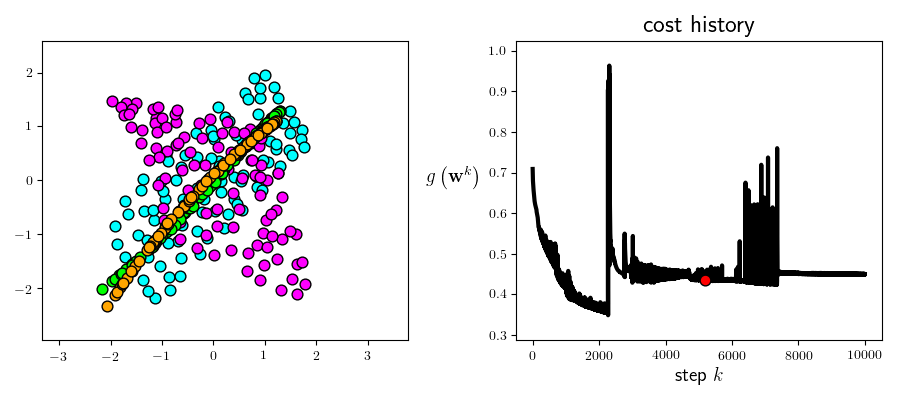
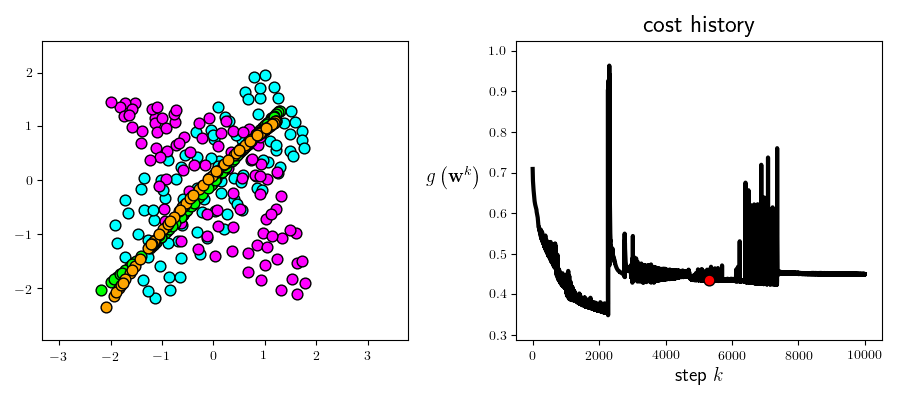
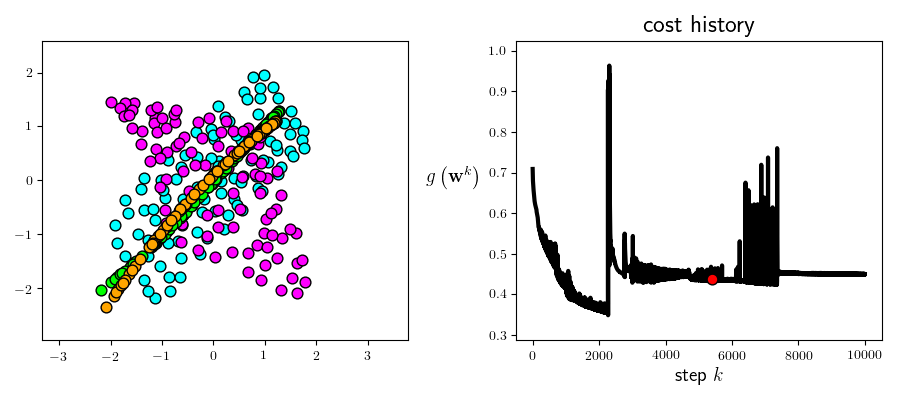
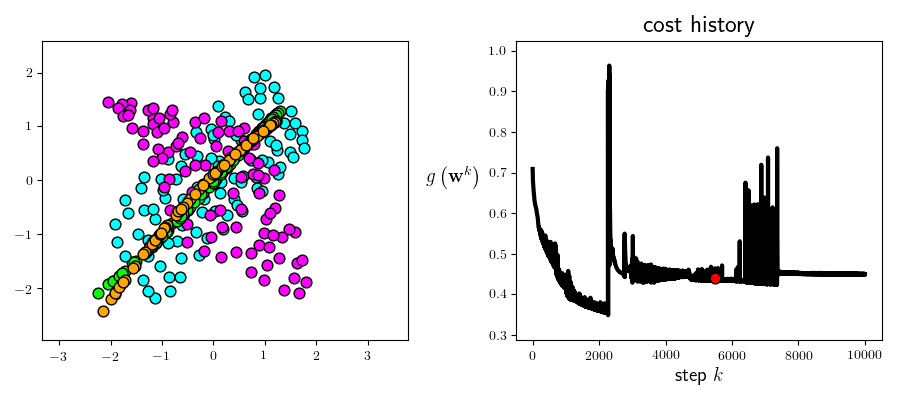
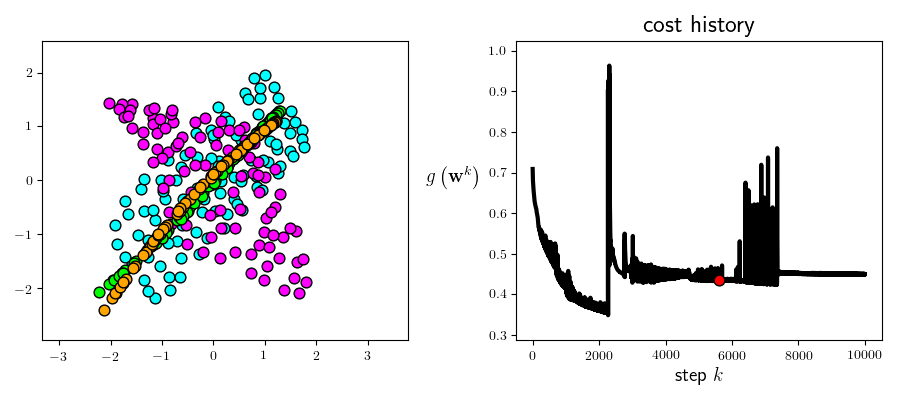
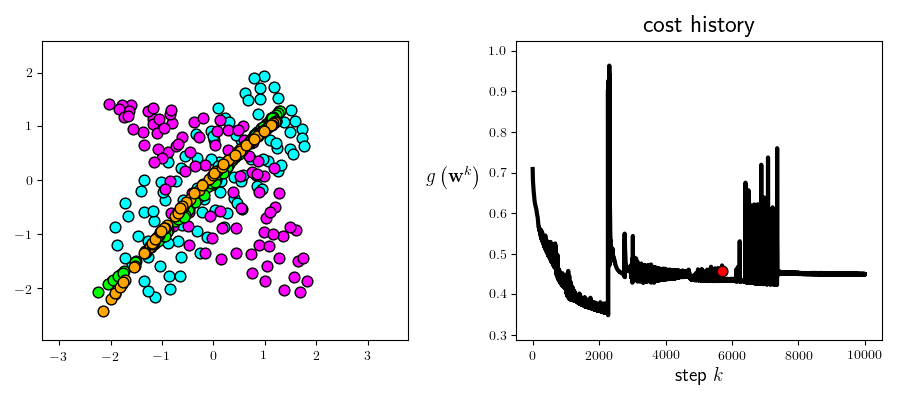
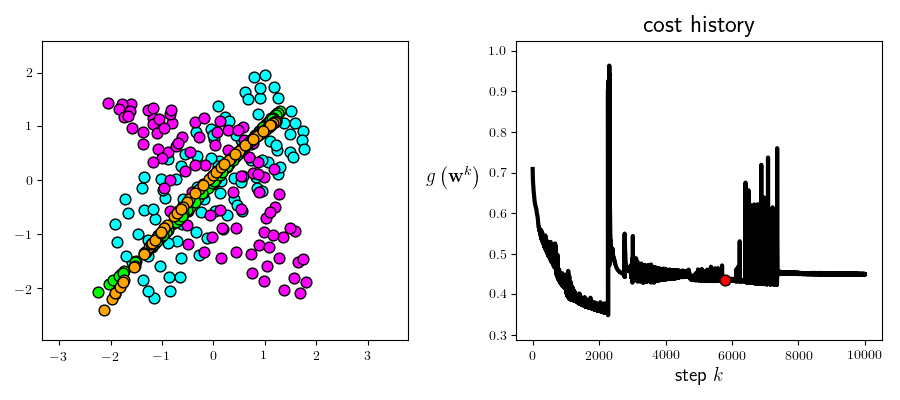
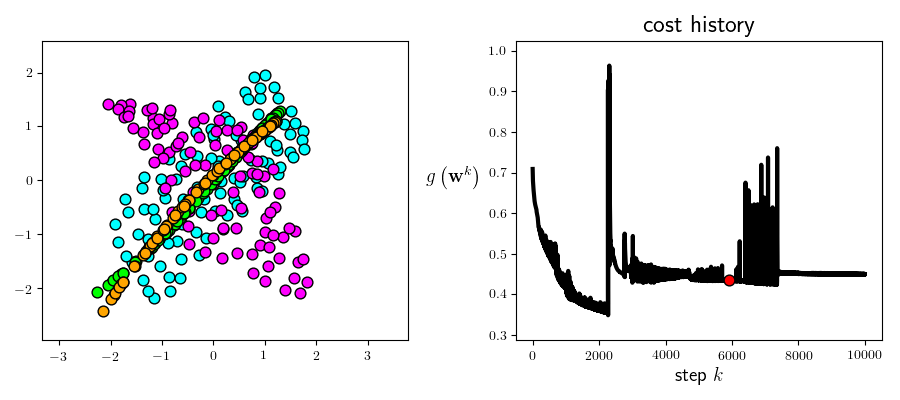
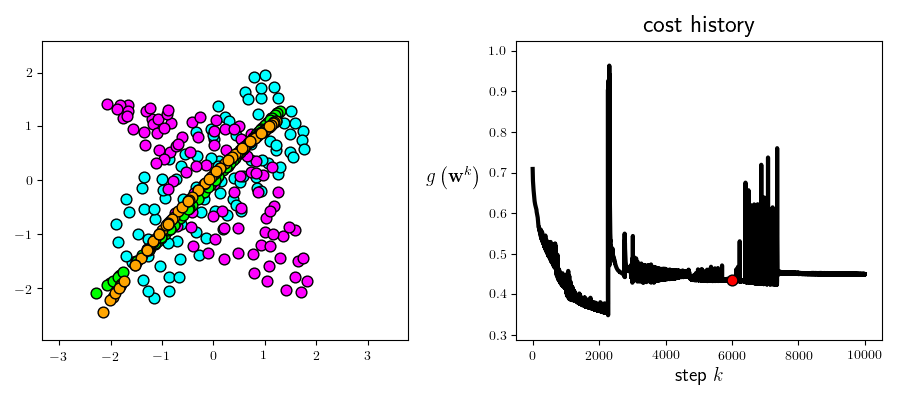
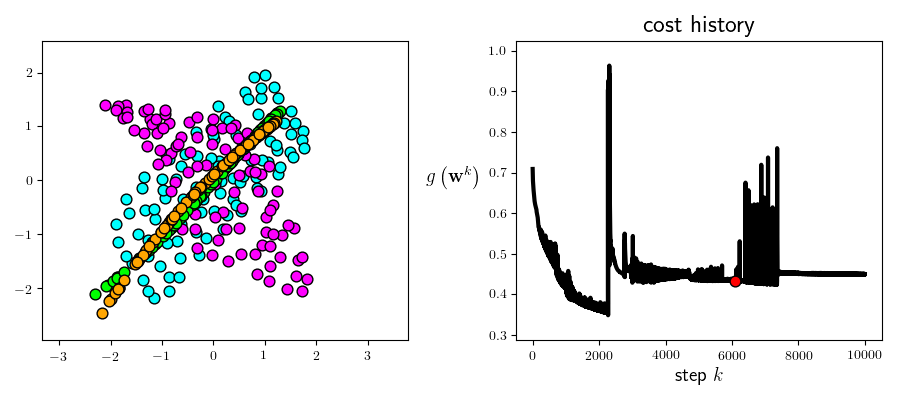
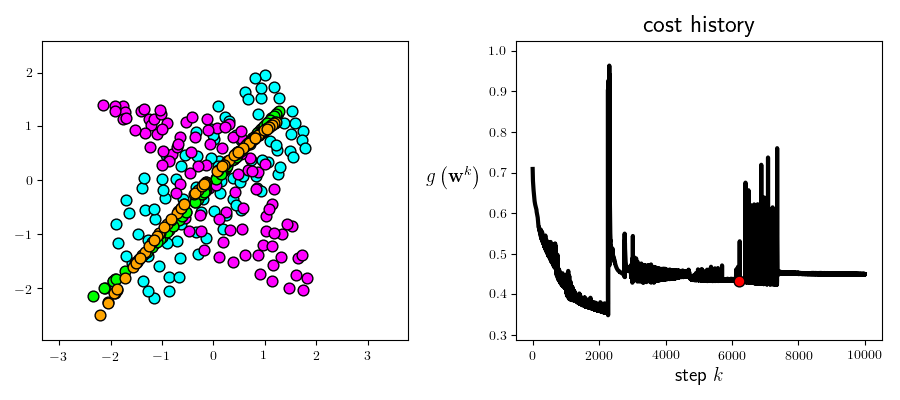
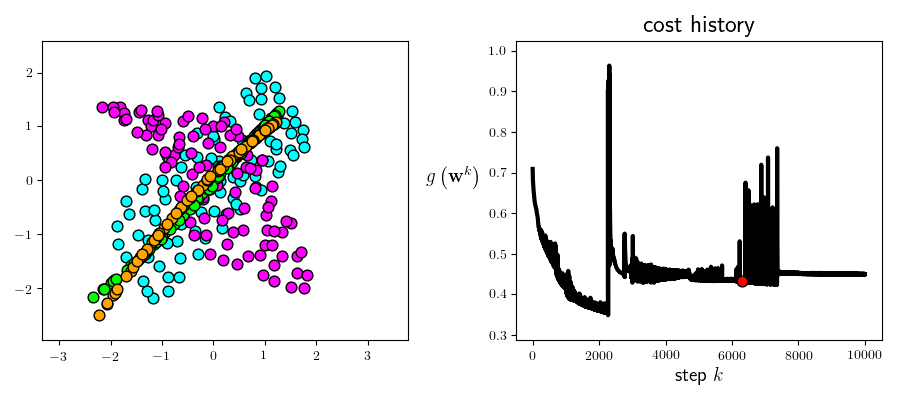
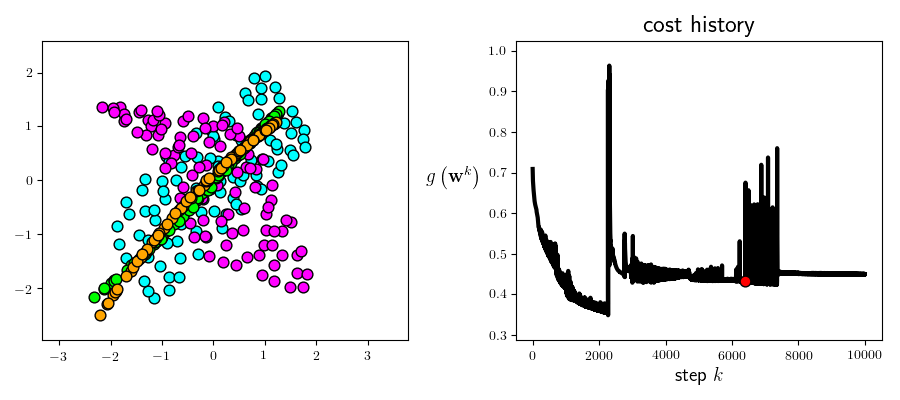
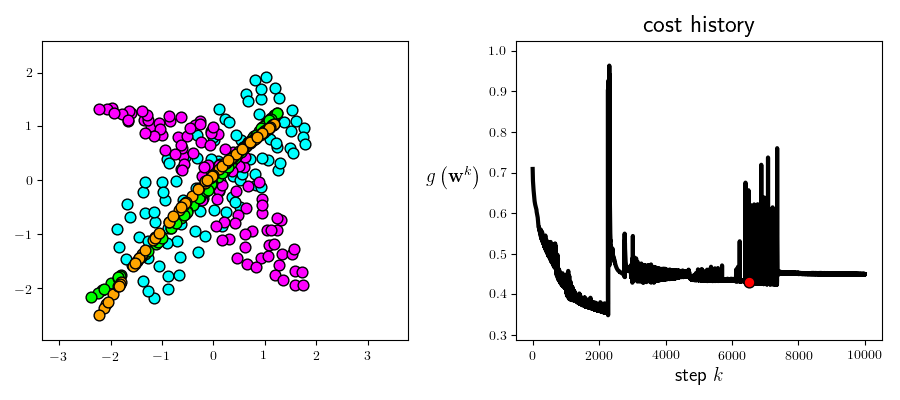
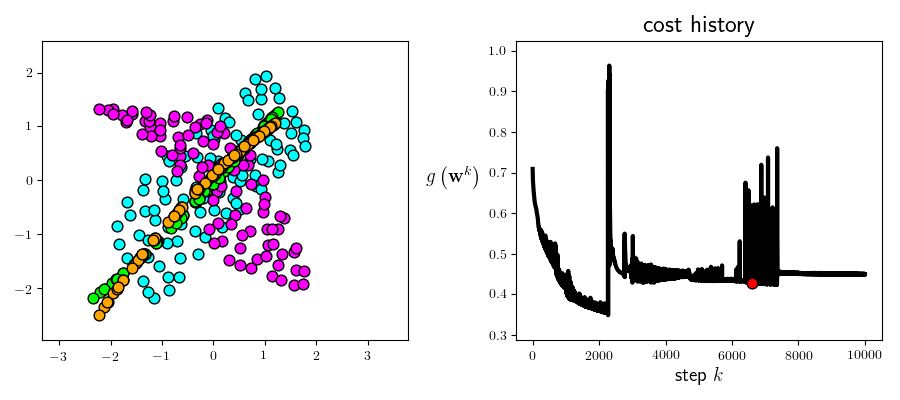
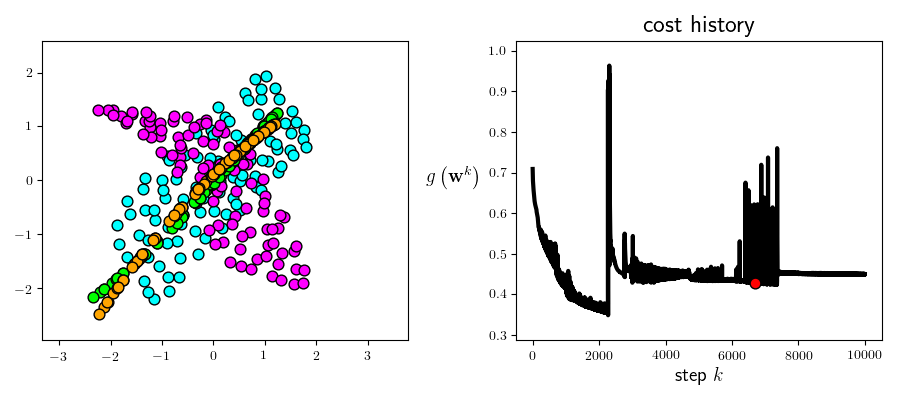
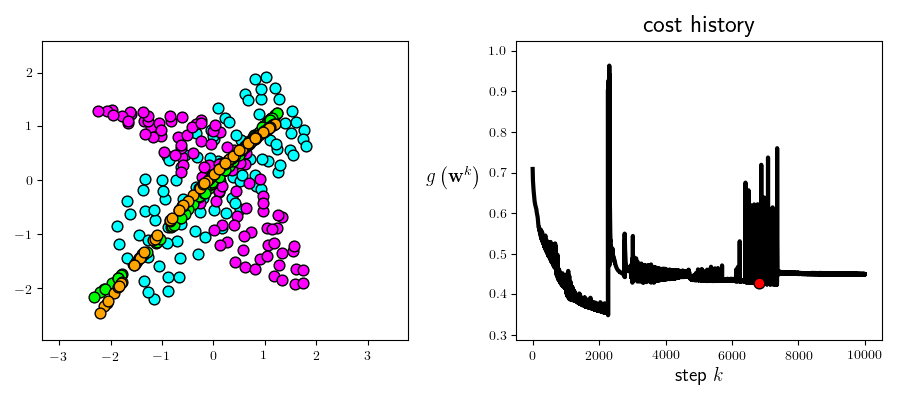
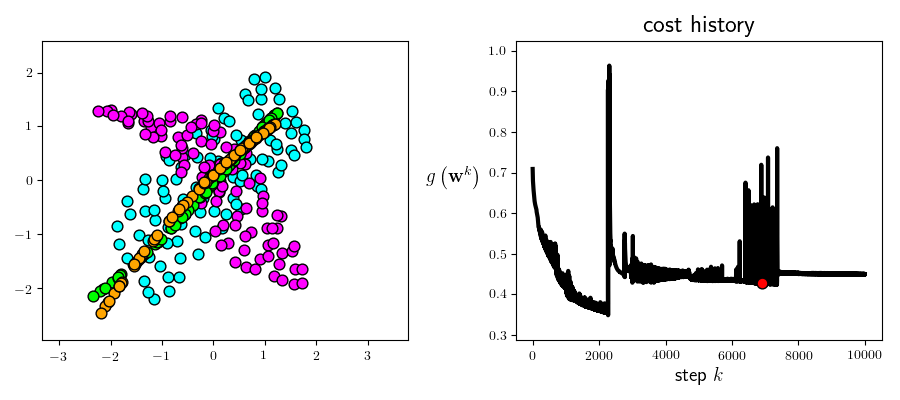
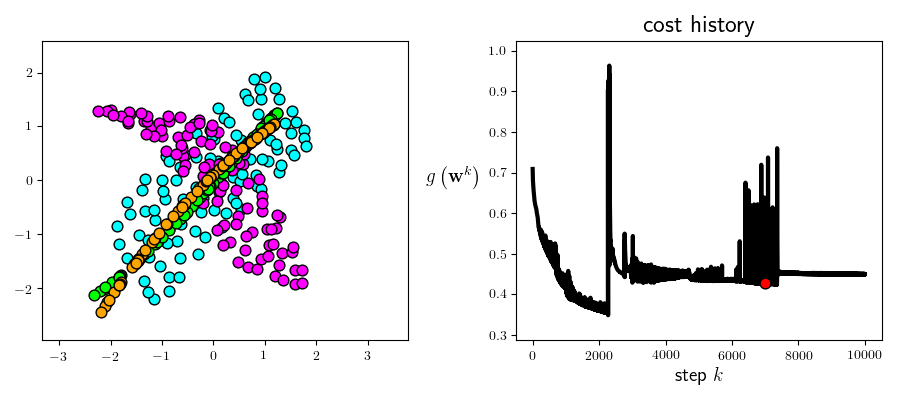
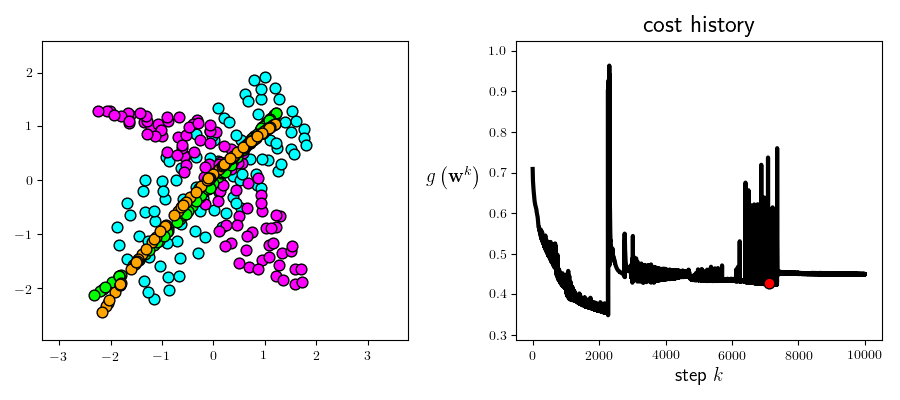
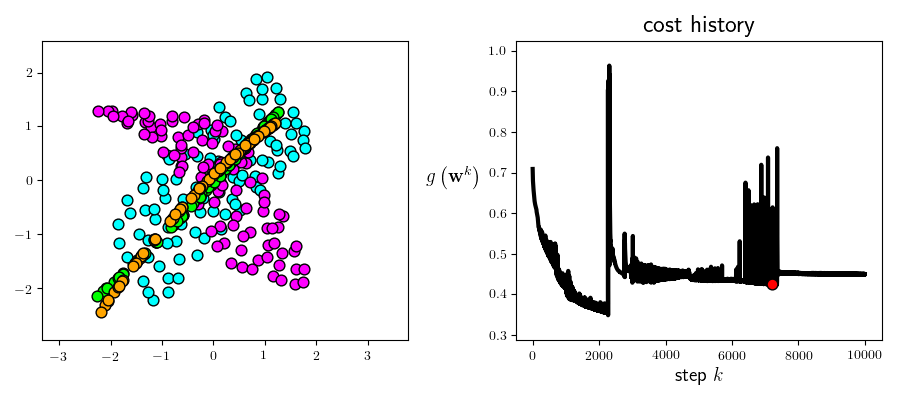
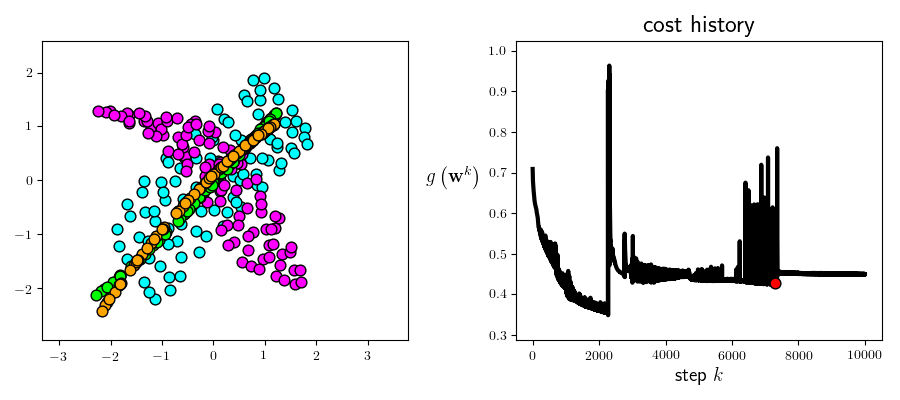
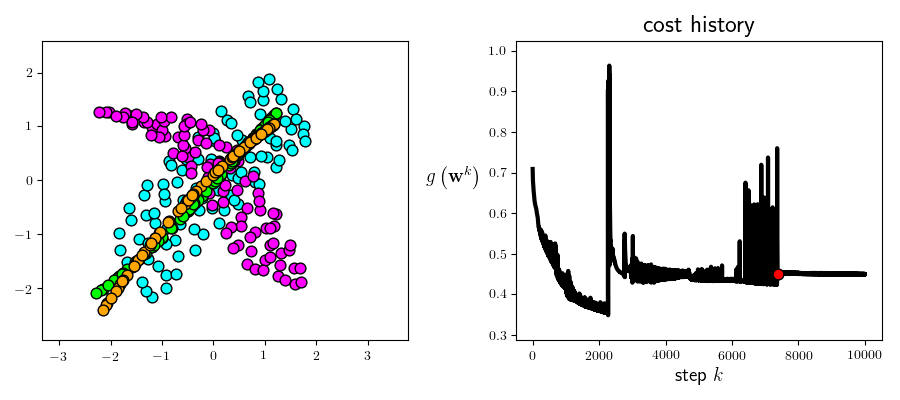
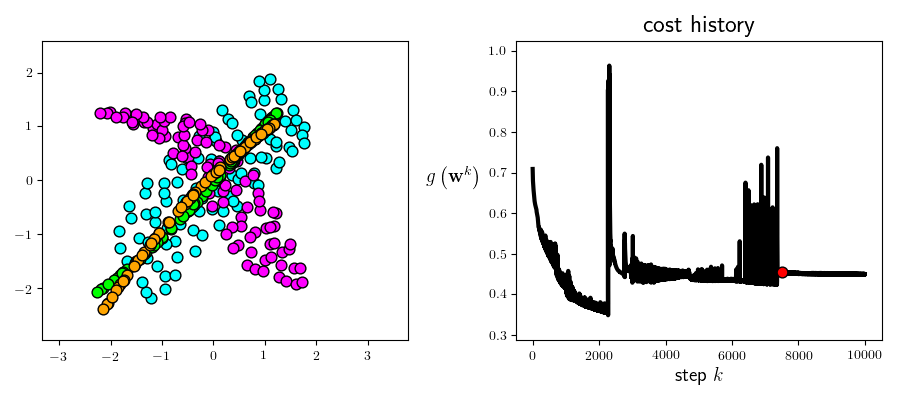
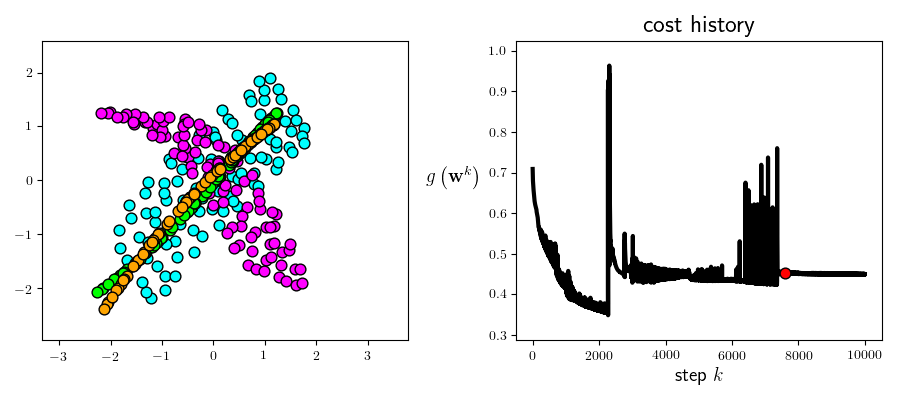
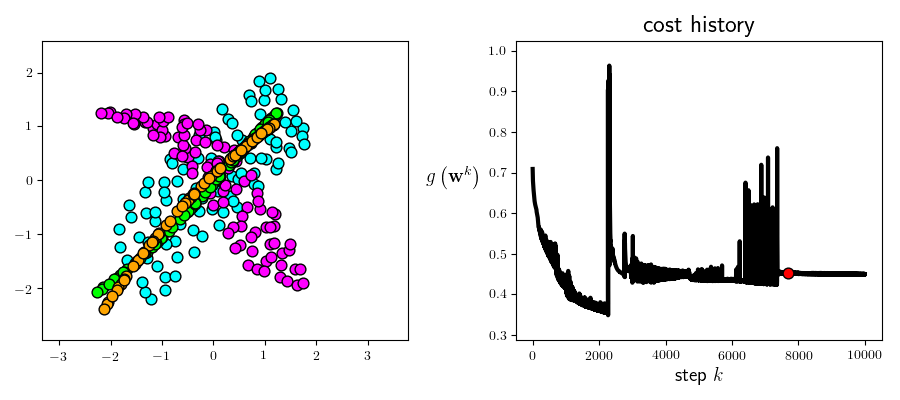
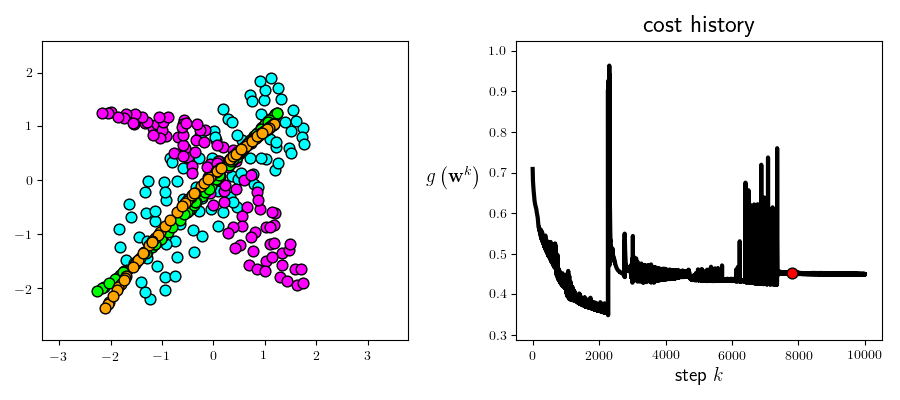
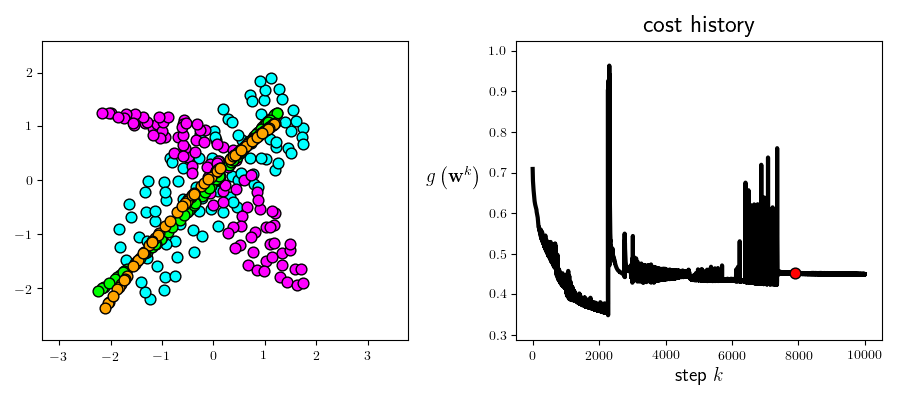
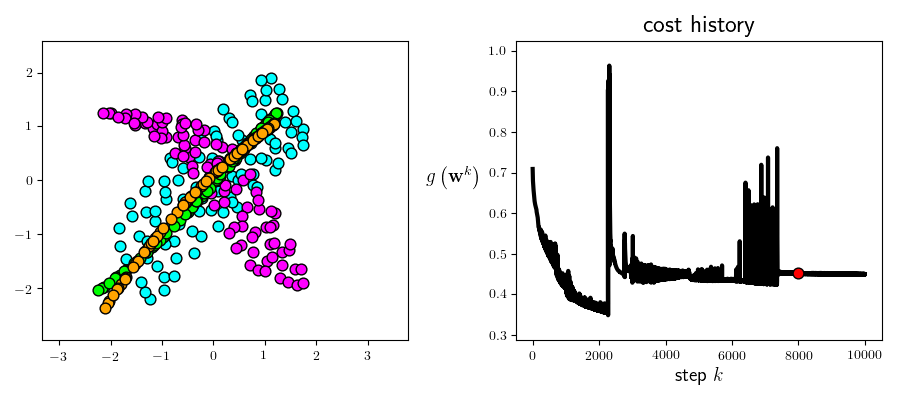
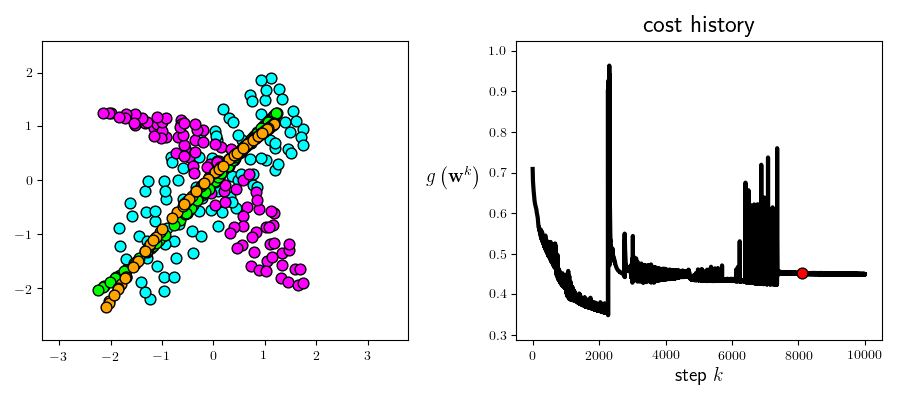
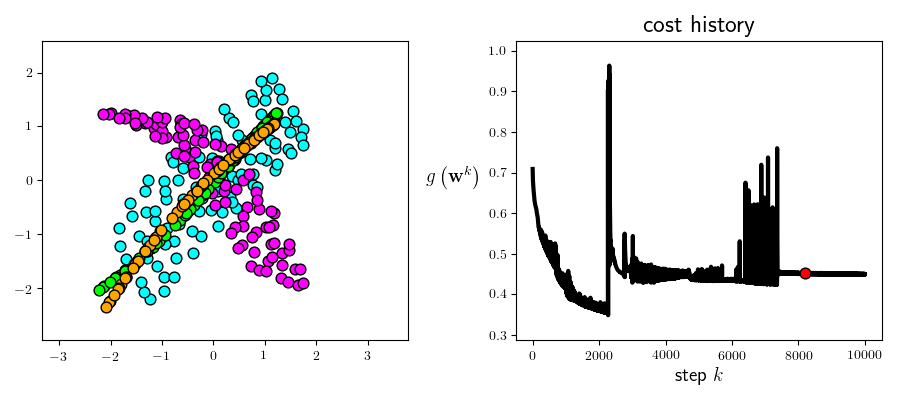
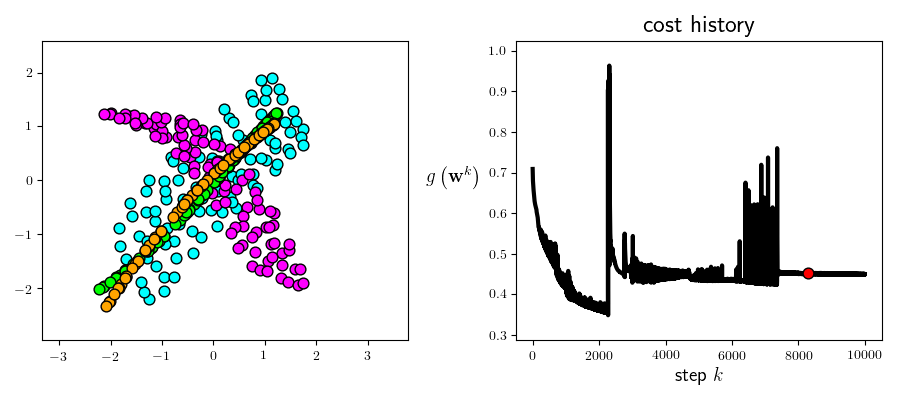
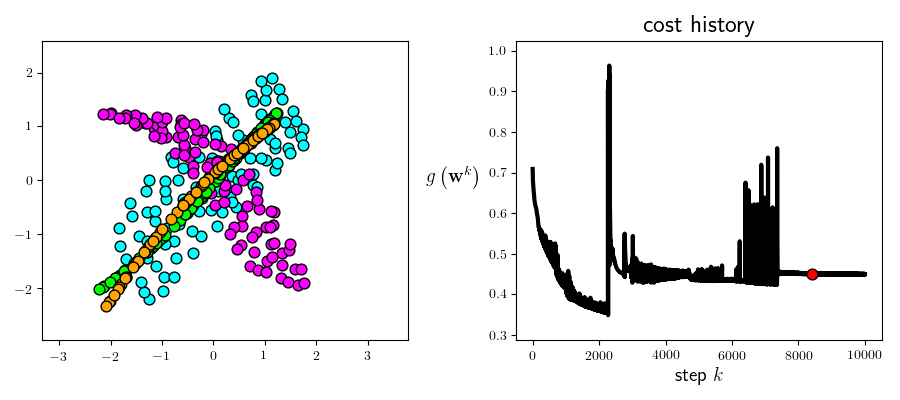
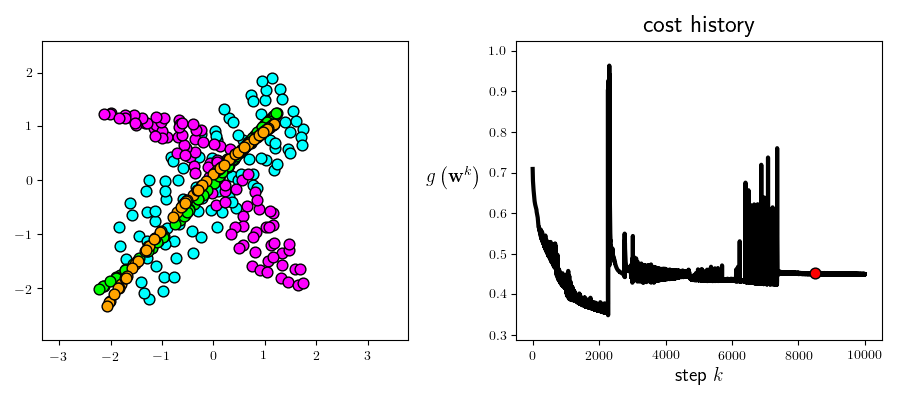
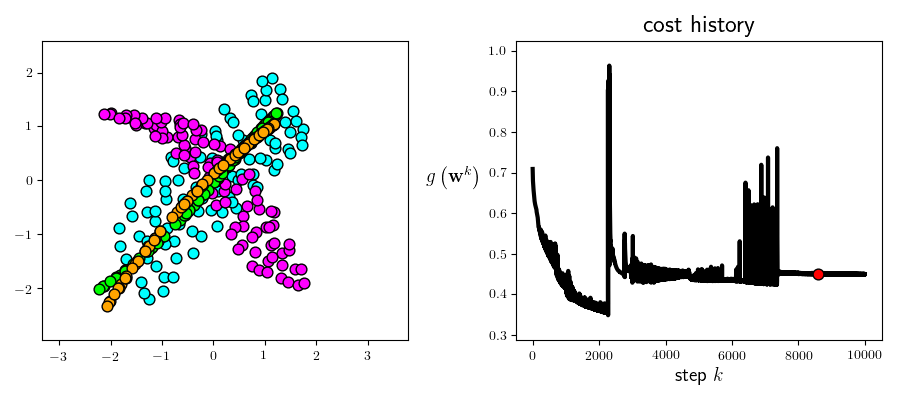
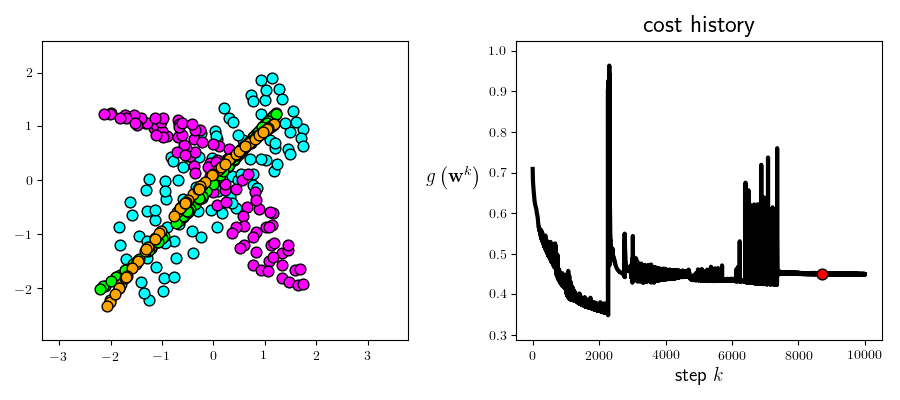
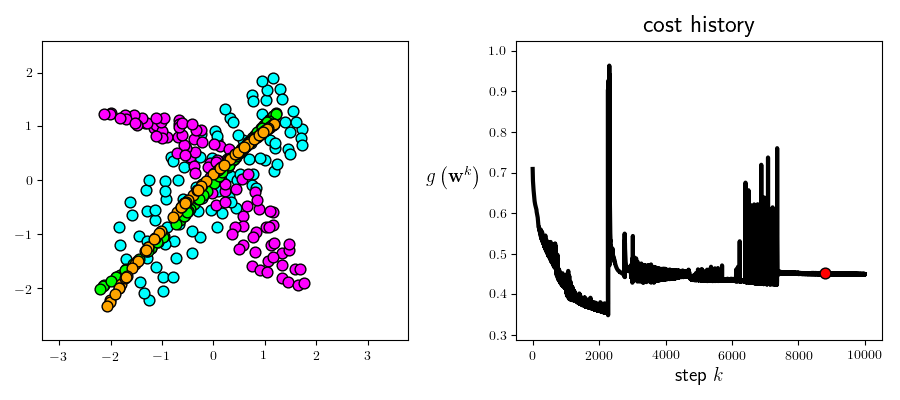
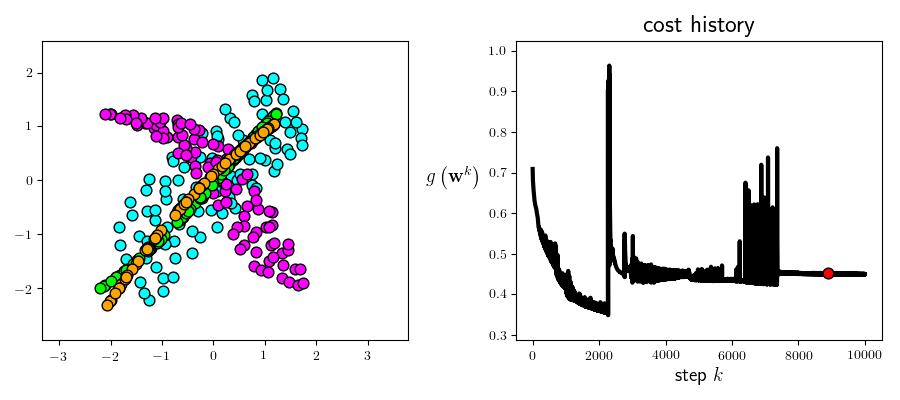
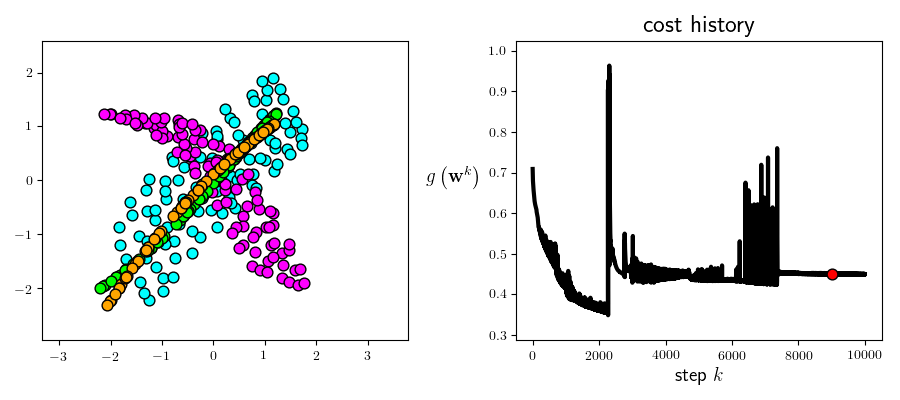
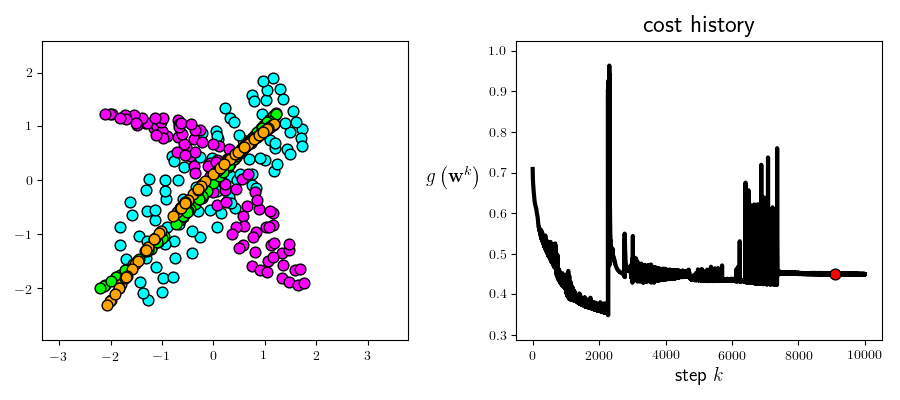
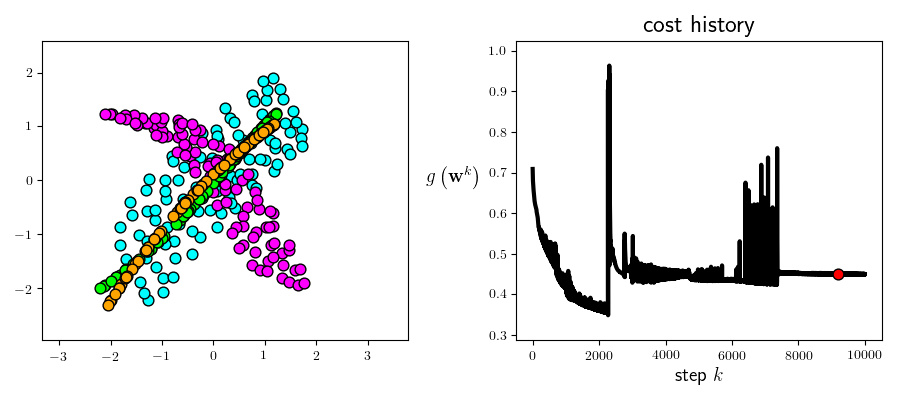
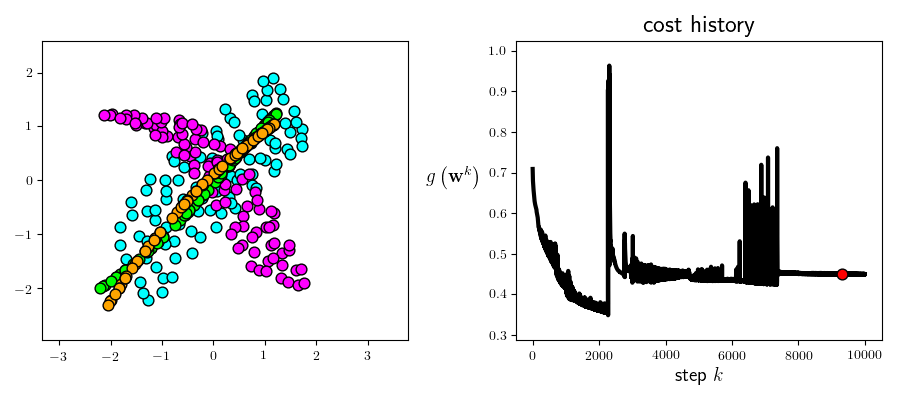
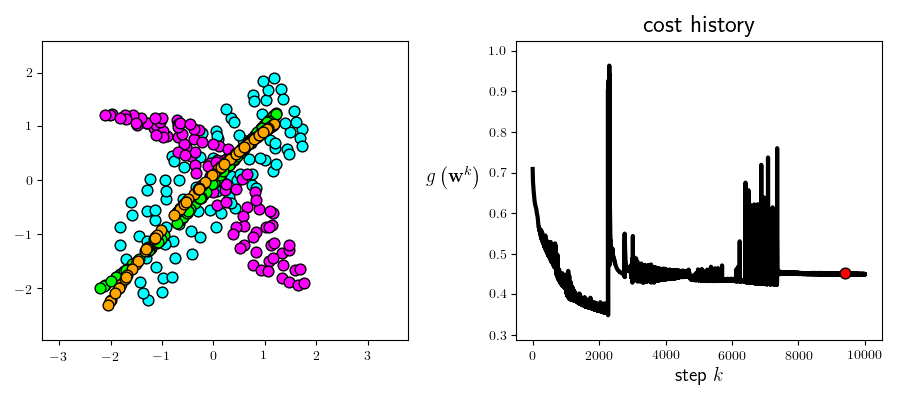
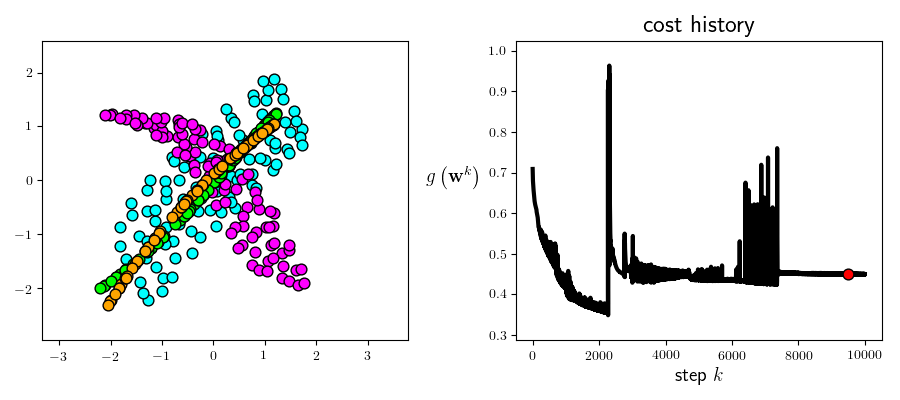
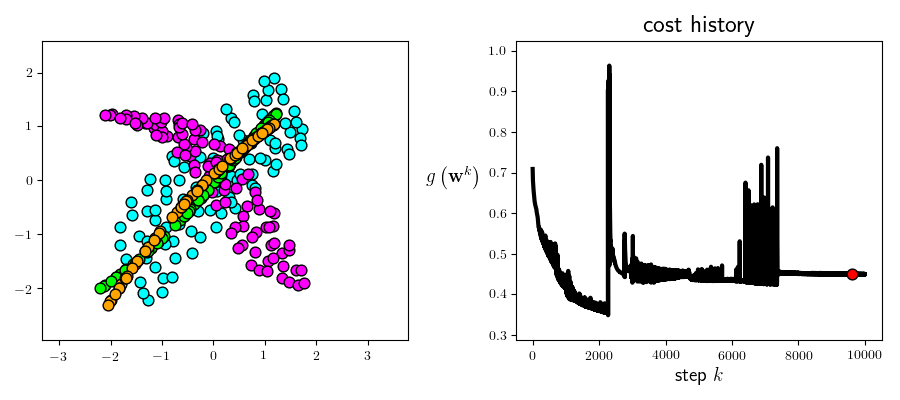
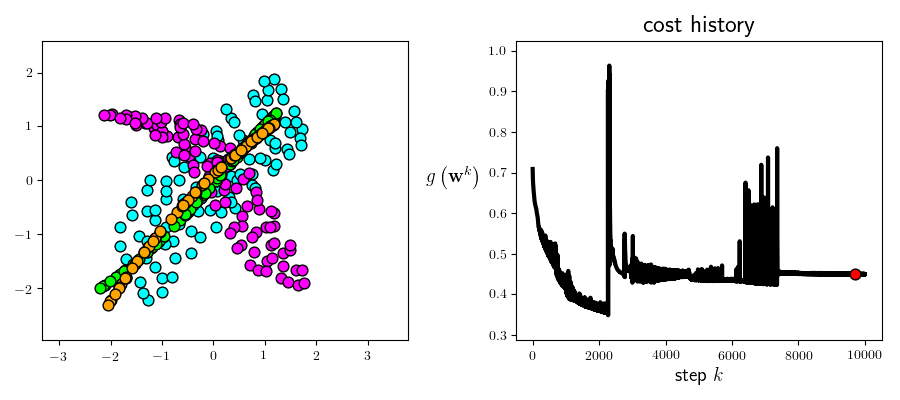
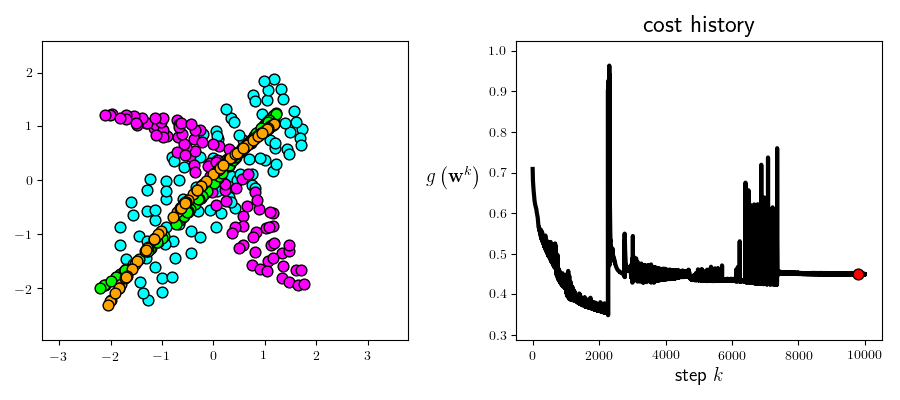
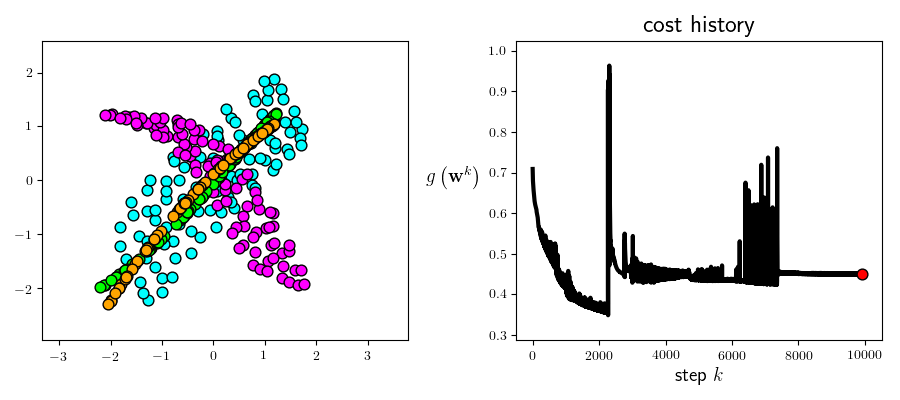
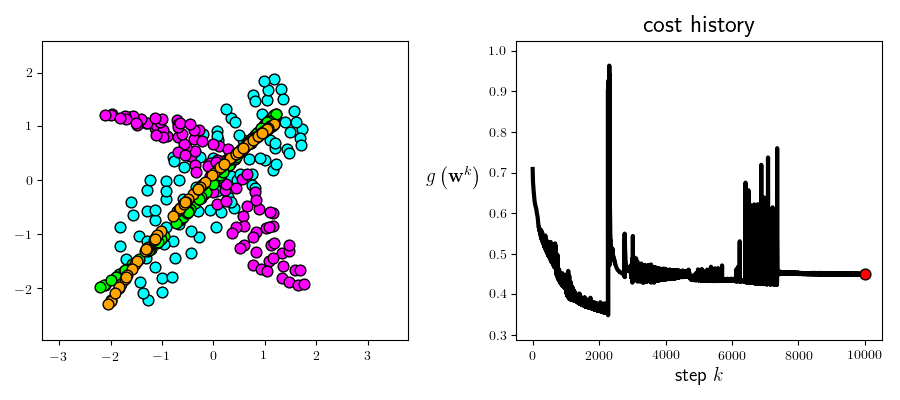

In [26]:
# show a plot of the distribution of each feature
frames = 100
demo4 = feature_plotter.Visualizer()
demo4.shifting_distribution(run4,frames,x,show_history = True,normalize = True)

#### <span style="color:#a50e3e;">Example 3. </span>  The shifting distributions / internal covariate shift of a multilayer perceptron

In [52]:
# This code cell will not be shown in the HTML version of this notebook
# load in mnist test set
csvname = '/Users/Nurgetson/Desktop/mnist/mnist_test_contrast_normalized.csv'
data = np.loadtxt(csvname,delimiter = ',')

# get input/output pairs
x = data[:-1,:]
y = data[-1:,:] 

### run gradient descent to minimize a multilayer perceptron model ###
alpha_choice = 10**(0); max_its = 10;
w = nonlib.initializers.initialize_network_weights(layer_sizes = [784,10,10],scale = 0.1)

run5 = nonlib.basic_runner.Setup(x,y,feature_transforms,'multiclass_softmax',normalize = 'sphere')
run5.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)
count_history_1 = [run5.multiclass_counting_cost(v) for v in run5.weight_history]

### run gradient descent to minimize a batch normalized multilayer perceptron model  ###
alpha_choice = 10**(0); max_its = 10;
run6 = nonlib.basic_runner.Setup(x,y,feature_transforms_batch_normalized,'multiclass_softmax',normalize = 'sphere')
run6.fit(w=w,alpha_choice = alpha_choice,max_its=max_its)
count_history_2 = [run6.multiclass_counting_cost(v) for v in run6.weight_history]

<IPython.core.display.Javascript object>


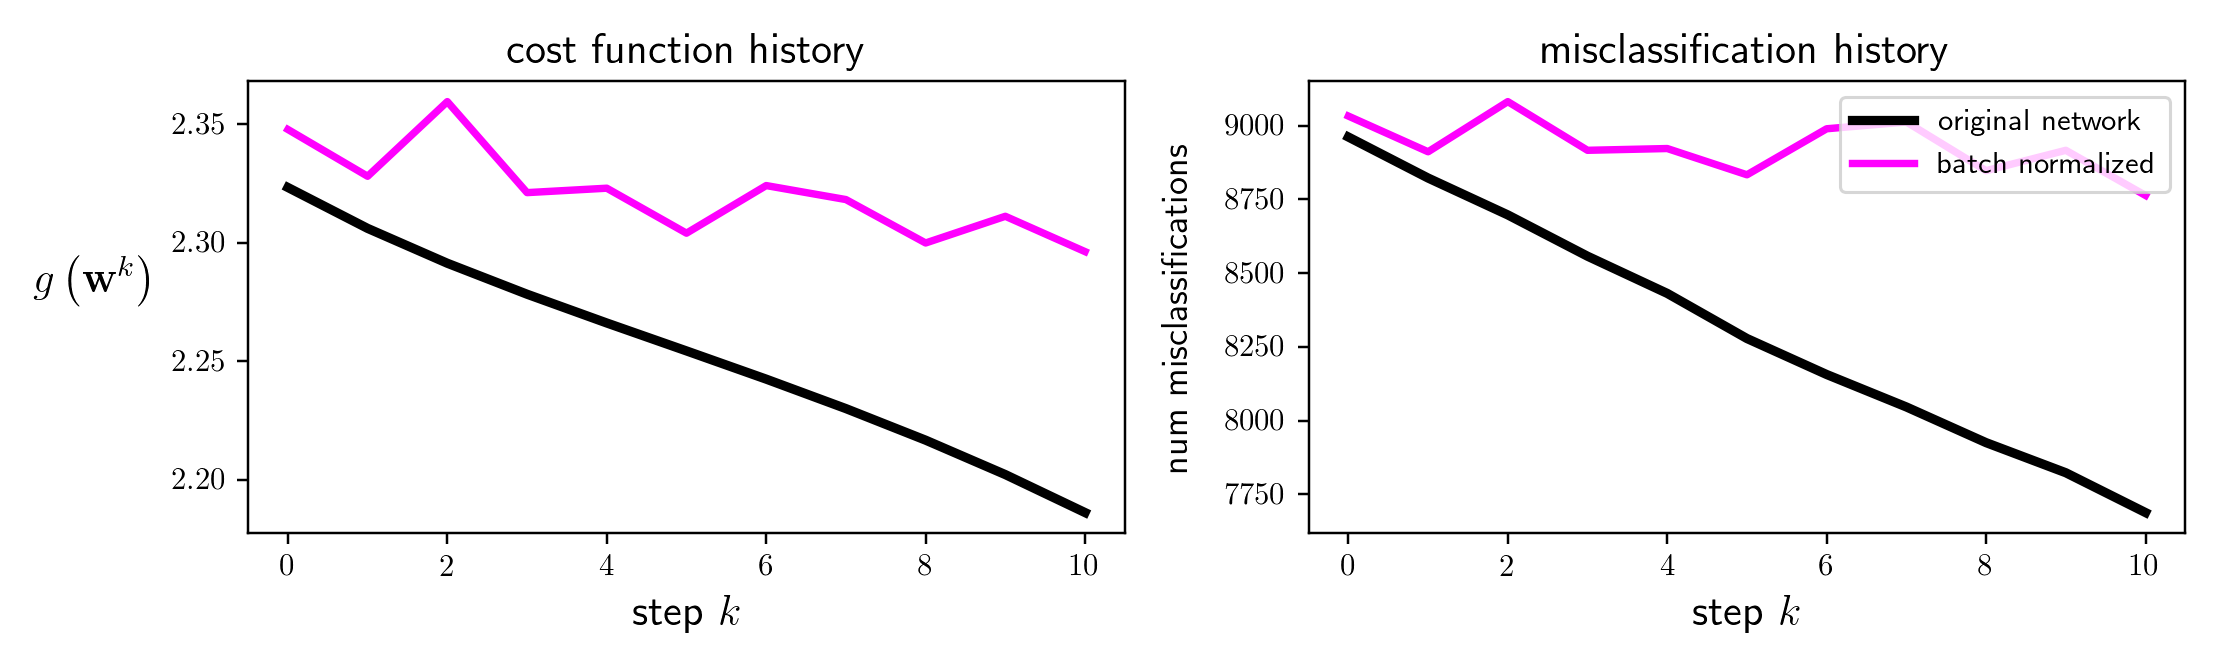

In [53]:
# plot the cost function history for a given run
classification_plotter.plot_cost_histories([run5.cost_history,run6.cost_history],[count_history_1,count_history_2],start = 0,labels = ['original network','batch normalized'])